# EHH decay artwork

## Setup

In [1]:
%run setup.ipynb
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}
rcParams['figure.dpi'] = 120
rcParams['figure.facecolor'] = 'w'

In [2]:
# grab the npy array made in ag1000g paper 1 vgsc notebook
p1clus = np.load('../data/vgsc_cluster_membership.npy')

In [3]:
# make this into a dictionary
p1list = [a.decode("utf-8") for a in p1clus]
p1list = np.asarray(p1list)
np.unique(p1list)[1:], len(p1list)

(array(['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5'], 
       dtype='<U2'), 1530)

In [4]:
nlist = list(np.unique(p1list)[1:])
nlist

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

In [5]:
clust_dict = {n: set(np.nonzero(p1list == n)[0]) for n in nlist}
#clust_dict['S2']

In [6]:
tbl_variants_selected = etl.frompickle('../data/tbl_variants_missense_selected.pkl')
tbl_variants_selected

0|CHROM,1|POS,2|num_alleles,3|REF,4|ALT,5|AC,6|ALTIX,7|FILTER_PASS,8|NoCoverage,9|LowCoverage,10|HighCoverage,11|LowMQ,12|HighMQ0,13|RepeatDUST,14|RepeatMasker,15|RepeatTRF,16|FS,17|HRun,18|QD,19|ReadPosRankSum,20|SNPEFF_Allele,21|SNPEFF_Annotation,22|SNPEFF_HGVS_c,23|SNPEFF_HGVS_p,24|SNPEFF_Feature_ID,25|SNPEFF_CDS_pos,26|AF_AOM,27|AF_BFM,28|AF_GWA,29|AF_GNS,30|AF_BFS,31|AF_CMS,32|AF_GAS,33|AF_UGS,34|AF_KES,35|check_allele,36|exon_start,37|exon_end,38|exon,39|AGAP004707-RA,40|AGAP004707-RB,41|AGAP004707-RC,42|Davies-C1N2,43|Davies-C3N2,44|Davies-C5N2,45|Davies-C7N2,46|Davies-C8N2,47|Davies-C10N2,48|Davies-C11N2,49|Davies-C1N9,50|Davies-C8N9,51|Davies-C1N9ck
2L,2390177,2,G,A,198,0,True,0,3,8,0,0,False,False,False,0.12695,1,18.625,0.83496,A,missense_variant,n.761G>A,p.Arg254Lys,AGAP004707-RA,761,0.0,0.0,0.0,0.0,0.0,0.316363636364,0.214285714286,0.0,0.0,True,2390129,2390341,7,R254K,R254K,R254K,R260K,R217K,R260K,R260K,R271K,R260K,R260K,R260K,R271K,R260K
2L,2391228,3,G,C,10,0,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,C,missense_variant,n.1204G>C,p.Val402Leu,AGAP004707-RA,1204,0.0,0.0724637681159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2391228,3,G,T,9,1,True,0,0,12,0,0,False,False,False,2.0352,0,14.867,-1.1777,None,None,None,None,None,None,0.0,0.0652173913043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,2391156,2391320,10,V402L,V402L,V402L,V408L,V365L,,V408L,V419L,V408L,V408L,V408L,V419L,V408L
2L,2399997,2,G,C,38,0,True,0,1,7,0,0,False,False,False,13.359,0,15.688,0.11798,C,missense_variant,n.1396G>C,p.Asp466His,AGAP004707-RA,1396,0.0,0.0,0.0,0.0,0.0,0.0690909090909,0.0,0.0,0.0,True,2399898,2400173,11i+,D466H,D466H,D466H,D472H,D429H,D417H,D472H,D483H,D472H,D472H,D472H,D483H,D472H
2L,2400071,3,G,A,16,0,True,0,0,8,0,0,False,False,False,5.6875,0,16.969,1.3232,A,missense_variant,n.1470G>A,p.Met490Ile,AGAP004707-RA,1470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818181818,True,2399898,2400173,11i+,M490I,M490I,M490I,M496I,M453I,M441I,M496I,M507I,M496I,M496I,M496I,M507I,M496I


In [7]:
aa2pos = tbl_variants_selected.lookupone('AGAP004707-RA', 'POS')

In [8]:
aa2pos['R254K']

2390177

In [9]:
aa2pos['L995F']

2422652

In [10]:
aa2pos['L995S']

2422651

In [11]:
aa2pos['I1527T']

2429617

In [12]:
aa2pos['M490I']

2400071

In [13]:
aa2pos['V1254I']

2425077

In [14]:
callset_haps = np.load('../data/haps_phase1.npz')
haps = allel.HaplotypeArray(callset_haps['haplotypes'])
pos = allel.SortedIndex(callset_haps['POS'])
ann = callset_haps['ANN']

In [15]:
pos

0,1,2,3,4,...,341993,341994,341995,341996,341997
44688,44691,44732,44736,44756,...,5999246,5999251,5999252,5999253,5999254


In [16]:
def setup_ehh_data():
    global haps_ehh
    global pos_ehh

#     # load haplotypes
#     callset_haps = np.load('../data/haps_phase1.npz')
#     haps = allel.HaplotypeArray(callset_haps['haplotypes'])
#     pos = allel.SortedIndex(callset_haps['POS'])
#     ann = callset_haps['ANN']

    # perform allele count - needed to locate singletons  
    ac = haps.count_alleles(max_allele=3)

    # define types of variants to include in EHH analysis - should be mostly neutral
    loc_type_neutral = ((ann['Annotation'] == b'intergenic_region') | 
                        (ann['Annotation'] == b'intron_variant') |
                        (ann['Annotation'] == b'downstream_gene_variant') |
                        (ann['Annotation'] == b'upstream_gene_variant') |
                        (ann['Annotation'] == b'synonymous_variant') |
                        (ann['Annotation'] == b'3_prime_UTR_variant') |
                        (ann['Annotation'] == b'5_prime_UTR_variant') 
                        )
    print('neutral', np.count_nonzero(loc_type_neutral), loc_type_neutral.shape)

    # locate singletons - will exclude from EHH analysis
    # NB the EHH analysis doesn't need the multiallelics 
    loc_sgl_bi = (ac[:, :2].min(axis=1) == 1) & (ac.is_biallelic_01())
    loc_nosgl_bi = (ac[:, :2].min(axis=1) > 1) & (ac.is_biallelic_01())
    print('sgl/nosgl', np.count_nonzero(loc_sgl_bi), np.count_nonzero(loc_nosgl_bi), loc_nosgl_bi.shape)

    # these are the variants to use for EHH 
    loc_ehh = loc_type_neutral & loc_nosgl_bi
    
    # add back in driver mutations
    for aa in 'L995S', 'L995F', 'I1527T':
        loc_ehh[pos.locate_key(aa2pos[aa])] = True
    
    print('ehh', np.count_nonzero(loc_ehh), loc_ehh.shape)

    haps_ehh = haps[loc_ehh]
    pos_ehh = pos[loc_ehh]
    
setup_ehh_data()

neutral 326952 (341998,)
sgl/nosgl 107220 234555 (341998,)
ehh 225793 (341998,)


In [17]:
pos_ehh

0,1,2,3,4,...,225788,225789,225790,225791,225792
44691,44732,44756,44767,44872,...,5999246,5999251,5999252,5999253,5999254


In [18]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [19]:
cluster_labels = sorted(clust_dict)
cluster_labels

['F1', 'F2', 'F3', 'F4', 'F5', 'S1', 'S2', 'S3', 'S4', 'S5']

## Identify core haplotypes

In [20]:
haps_L995F = set(np.nonzero(haps[pos.locate_key(aa2pos['L995F']), :] == 1)[0])
len(haps_L995F)

775

In [21]:
haps_L995S = set(np.nonzero(haps[pos.locate_key(aa2pos['L995S']), :] == 1)[0])
len(haps_L995S)

430

In [22]:
haps_I1527T = set(np.nonzero(haps[pos.locate_key(aa2pos['I1527T']), :] == 1)[0])
len(haps_I1527T)

19

In [23]:
haps_M490I_1 = set(np.nonzero(haps[pos.locate_key(aa2pos['M490I']), :] == 1)[0])
len(haps_M490I_1)

16

In [24]:
haps_M490I_2 = set(np.nonzero(haps[pos.locate_key(aa2pos['M490I']), :] == 2)[0])
len(haps_M490I_2)

2

In [25]:
target_sets = clust_dict.copy()
wt = set(range(haps_ehh.shape[1]))
for s in clust_dict.values():
    wt = wt - s
target_sets['L1'] = haps_I1527T
target_sets['L2'] = haps_M490I_1
wt = wt - target_sets['L1']
wt = wt - target_sets['L2']
target_sets['wt'] = wt

In [26]:
target_labels = sorted(target_sets)
for l in target_labels:
    print(l, len(target_sets[l]))

F1 464
F2 14
F3 42
F4 38
F5 196
L1 19
L2 16
S1 108
S2 79
S3 165
S4 37
S5 36
wt 316


In [27]:
def plot_delta_af(core, flank, set1, set2, figsize=(10, 2)):
    
    # subset to region
    loc_region = pos_ehh.locate_range(core - flank, core + flank)
    pos_region = pos_ehh[loc_region]
    n_snps = pos_region.shape[0]
    haps_region = haps_ehh[loc_region]
    
    # compute delta allele frequency
    subpops = {set1: sorted(target_sets[set1]), set2: sorted(target_sets[set2])}
    acs = haps_region.count_alleles_subpops(subpops)
    aaf1 = acs[set1].to_frequencies()[:, 1]
    aaf2 = acs[set2].to_frequencies()[:, 1]
    delta_af = np.fabs(aaf1 - aaf2)
    loc_nz = delta_af > 0.1
    pos_region = pos_region[loc_nz]
    delta_af = delta_af[loc_nz]
    
    # plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.despine(ax=ax, offset=5)
#     x = np.concatenate([-np.arange(0, idx_core)[::-1], 
#                         np.arange(idx_core, n_snps) - idx_core])
#     y = delta_af

    ax.plot(pos_region, delta_af, marker='o', mec='k', mfc='none', linestyle=' ')
    loc_diff = delta_af > .9
    pos_diff = pos_region[loc_diff]
    ax.set_xticks(pos_diff)
    ax.set_xticklabels(pos_diff - core, rotation=90)
    ax.axvline(core, linestyle='--', lw=1)
    ax.grid(axis='both')
    ax.set_title('%s vs %s' % (set1, set2))
    ax.set_xlim(core - flank, core + flank)
    ax.set_ylabel('Delta allele frequency')
    ax.set_xlabel('Position relative to core (bp)')
    ax.set_ylim(-0.03, 1.03)


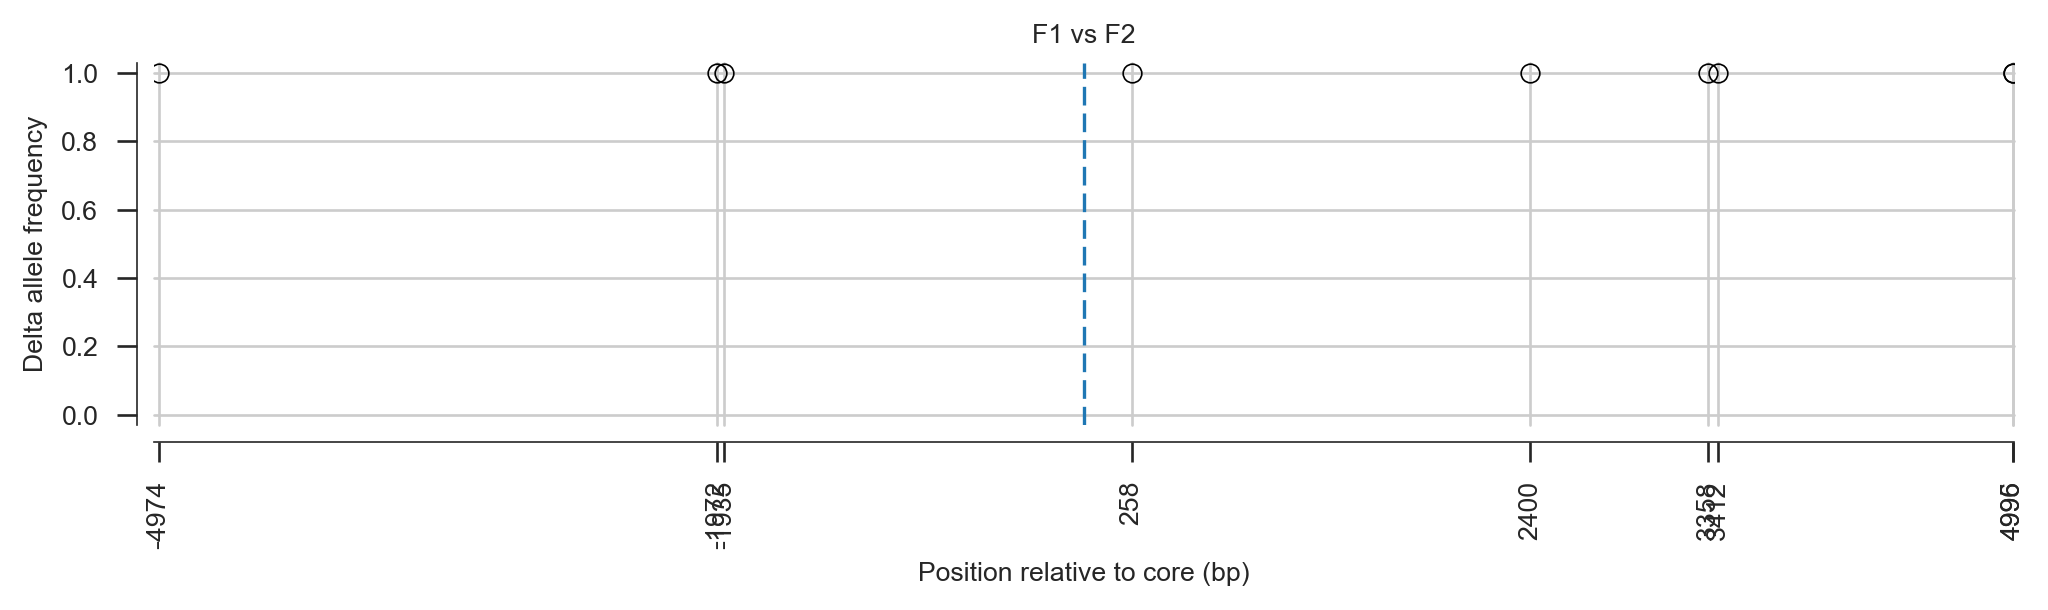

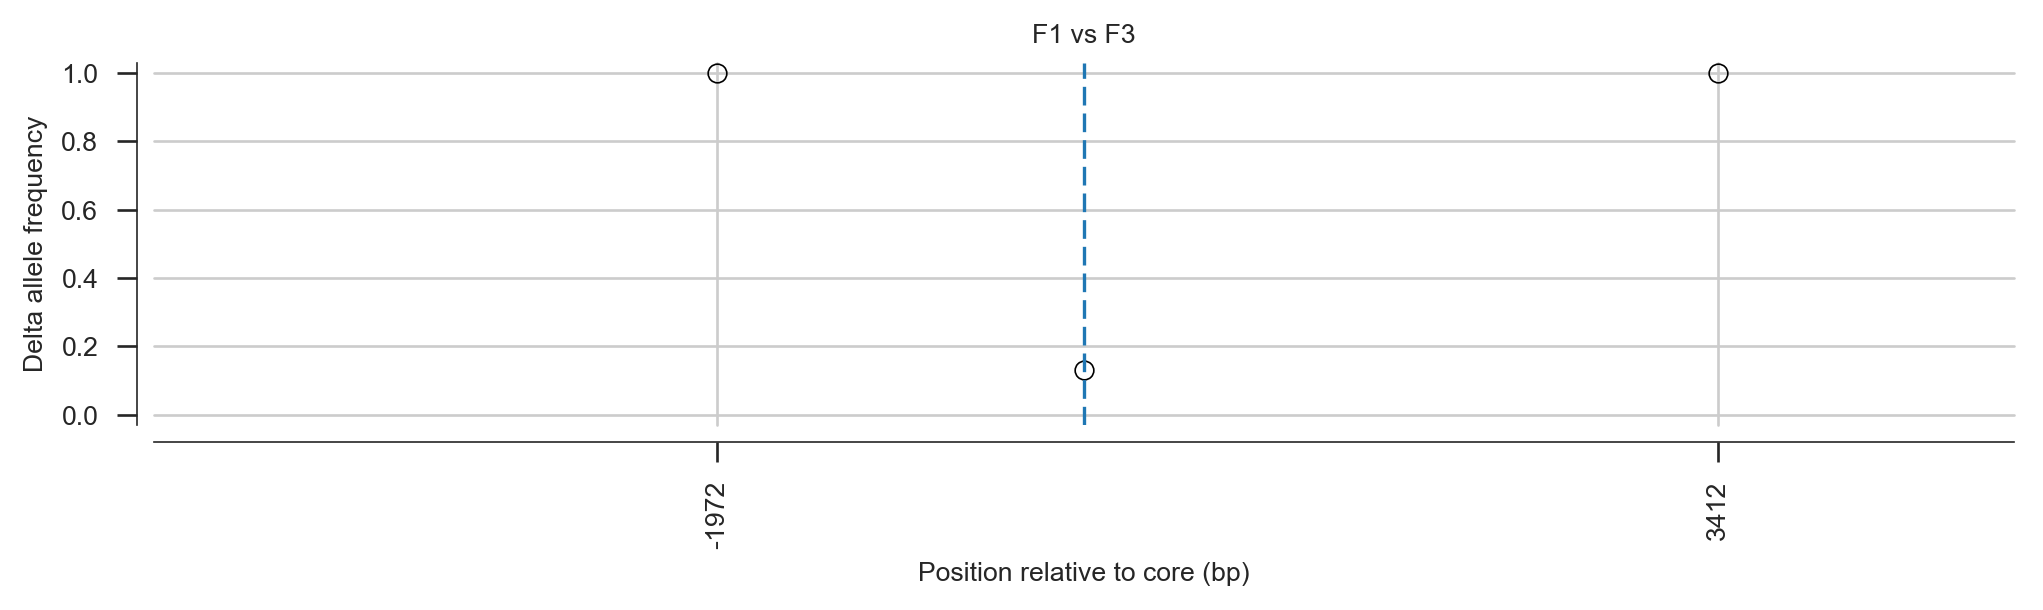

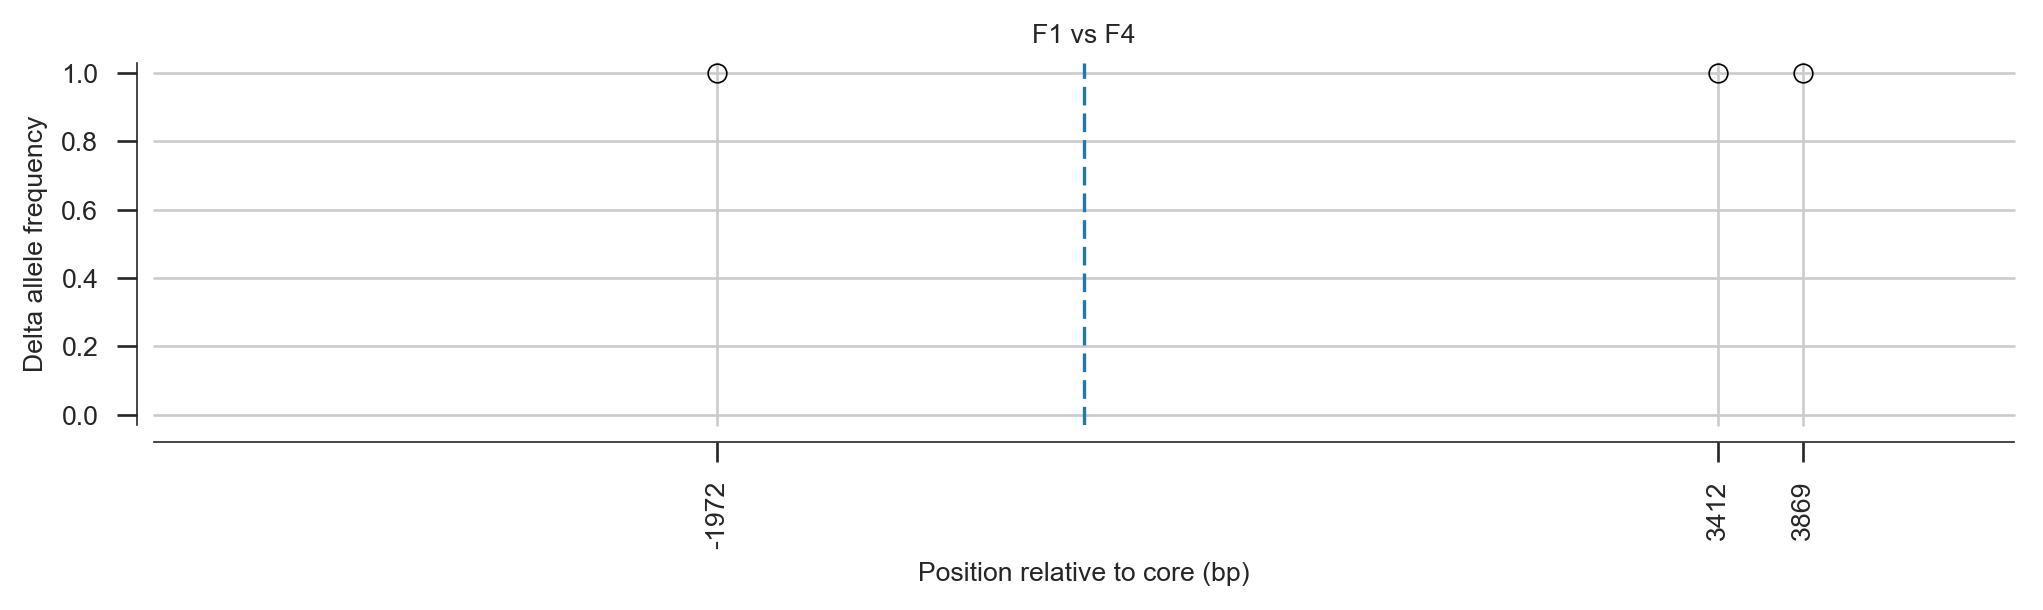

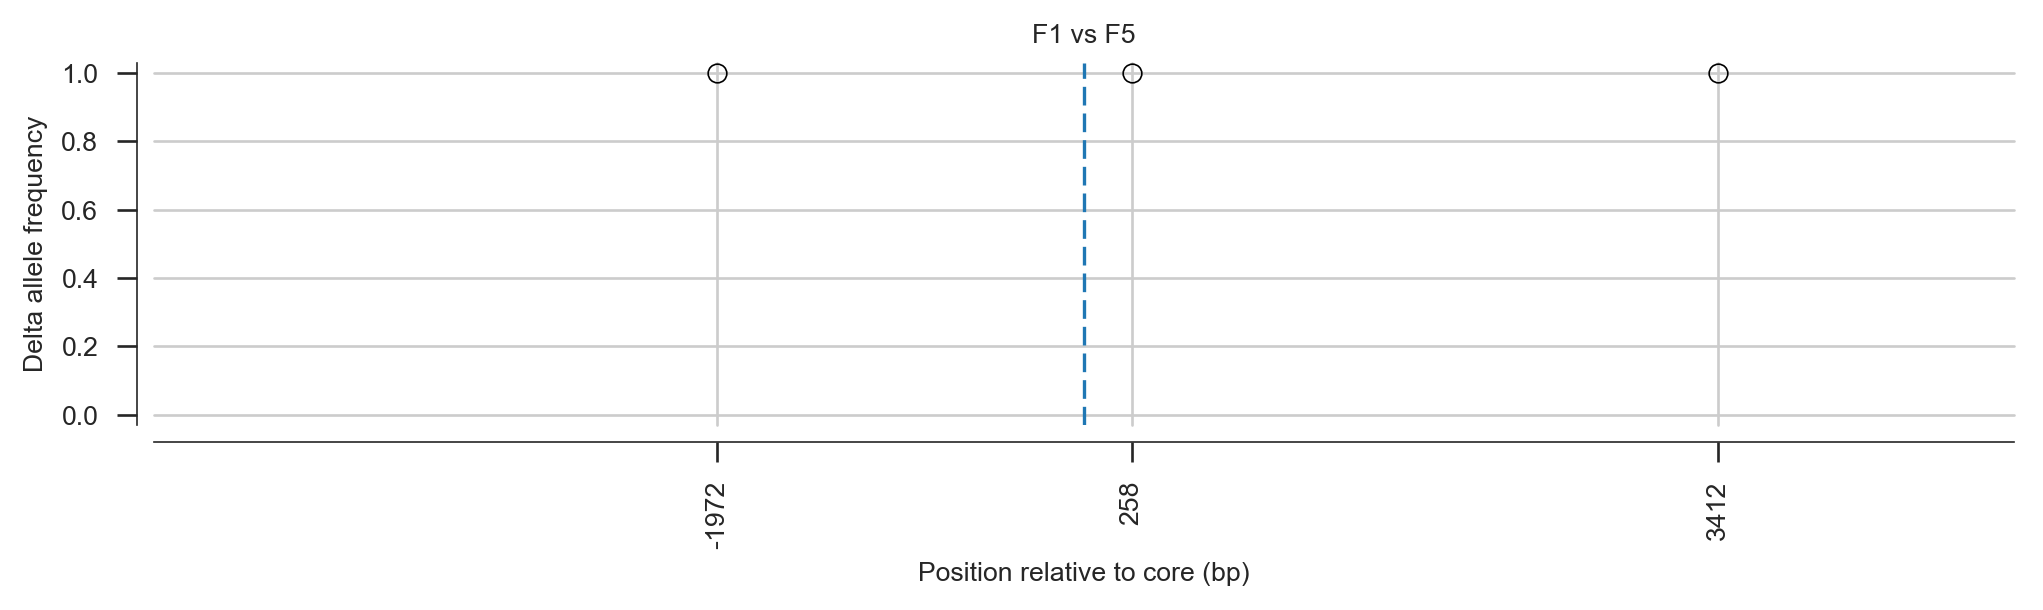

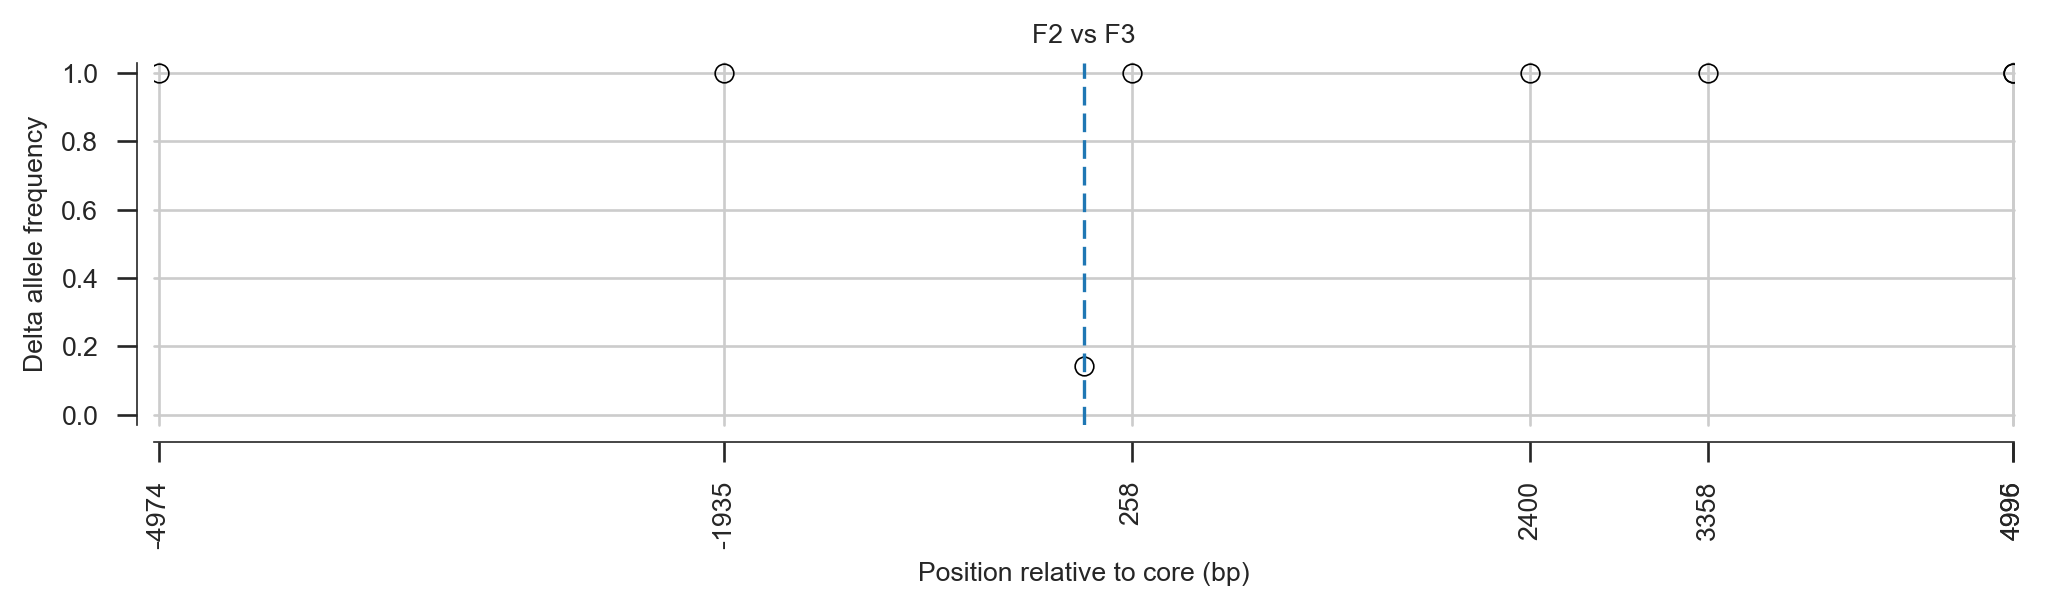

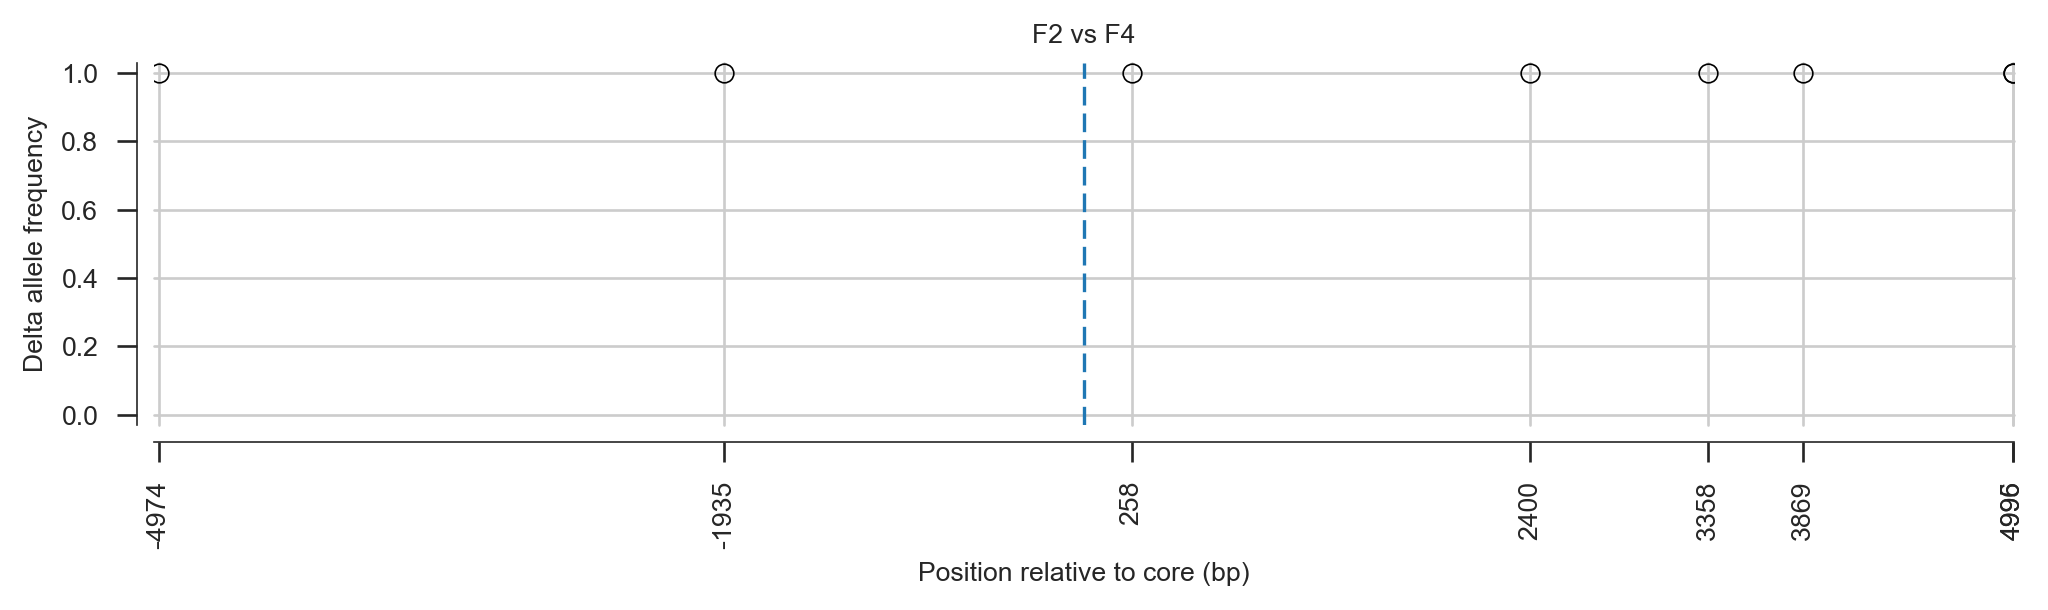

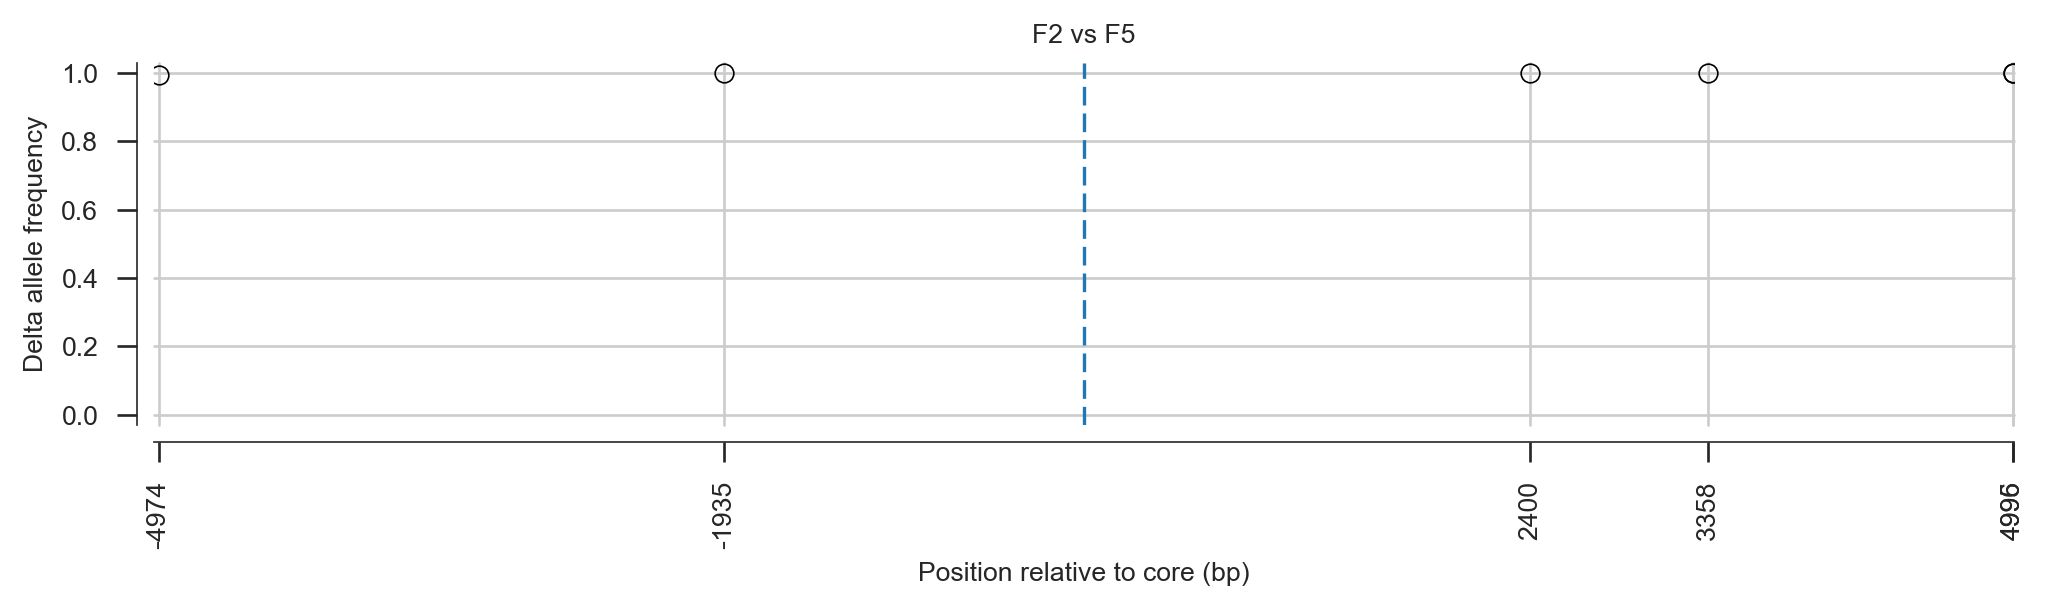

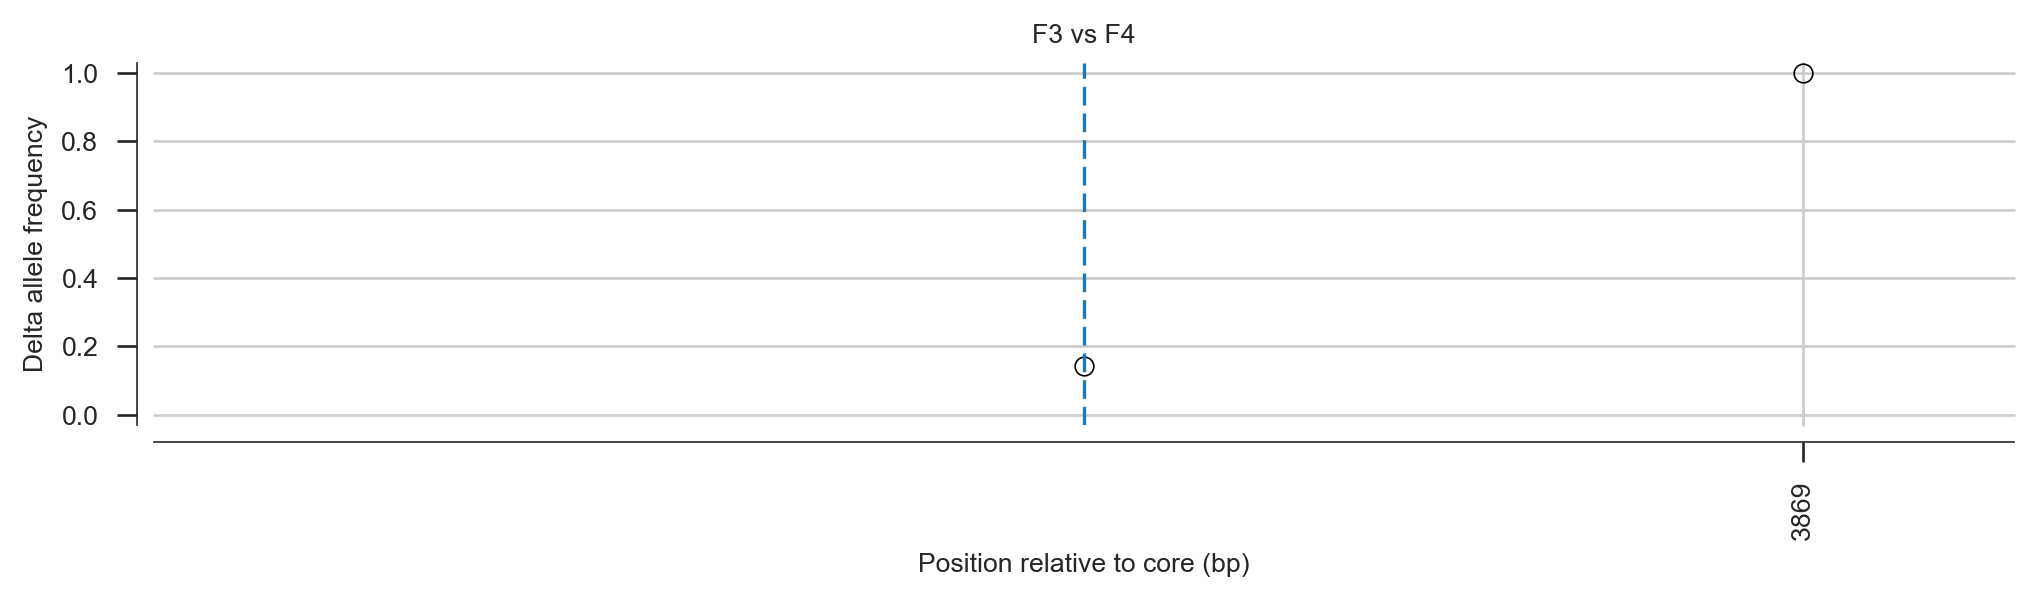

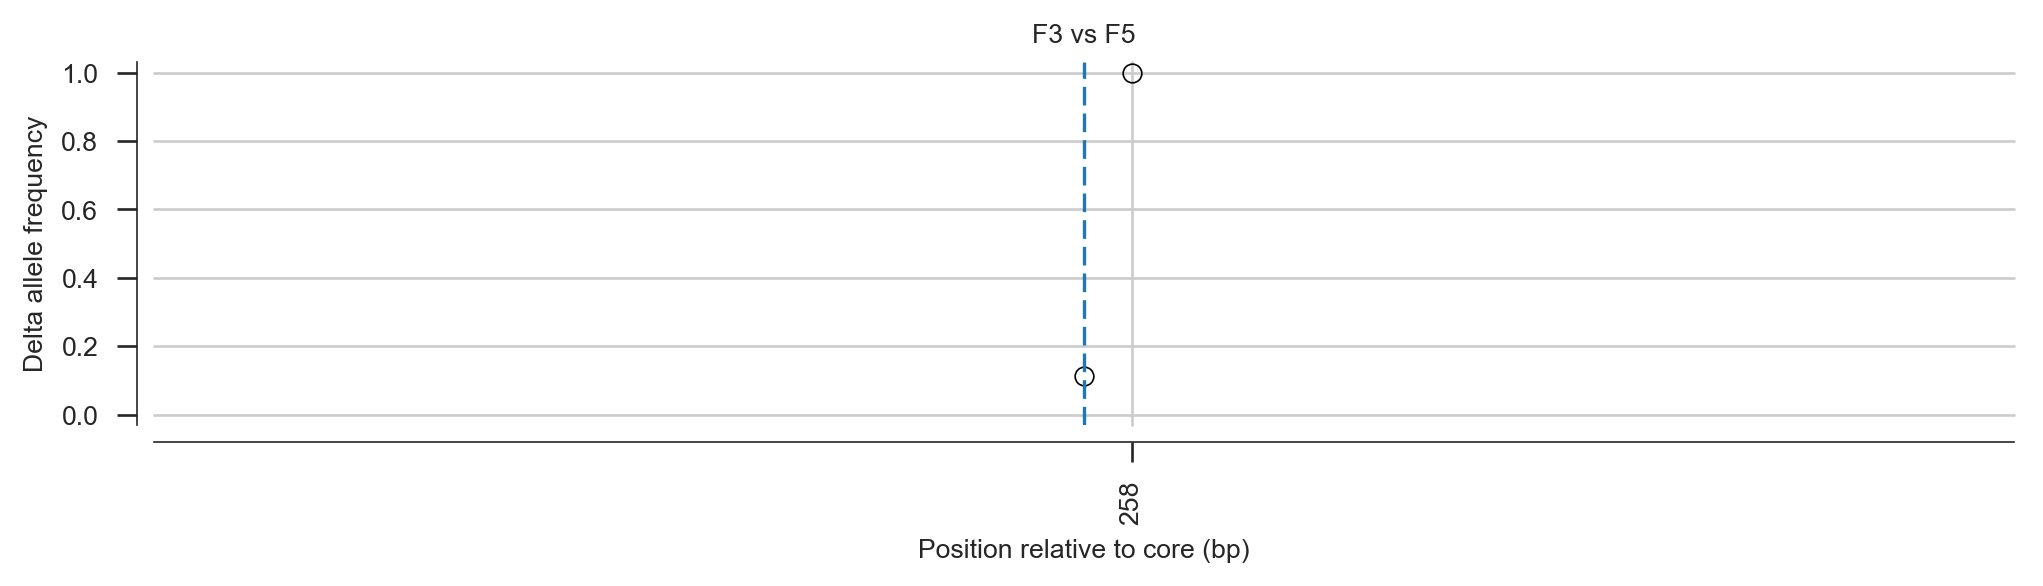

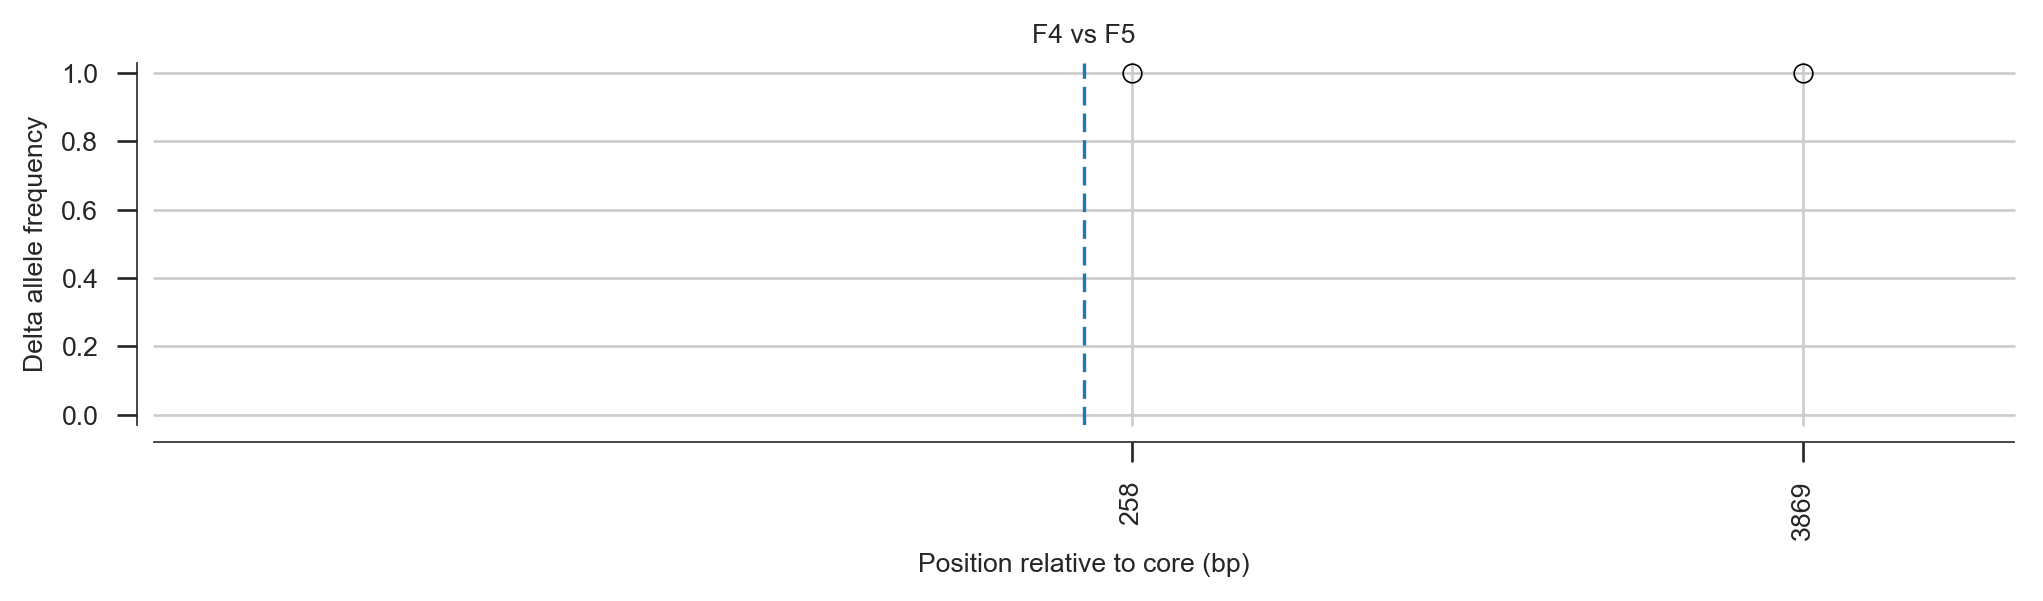

In [28]:
def analyse_995F_core_region():
    core = aa2pos['L995F']
    flank = 5000
    for set1, set2 in itertools.combinations(cluster_labels[:5], 2):
        plot_delta_af(core, flank, set1, set2)
        plt.show()
        
analyse_995F_core_region()

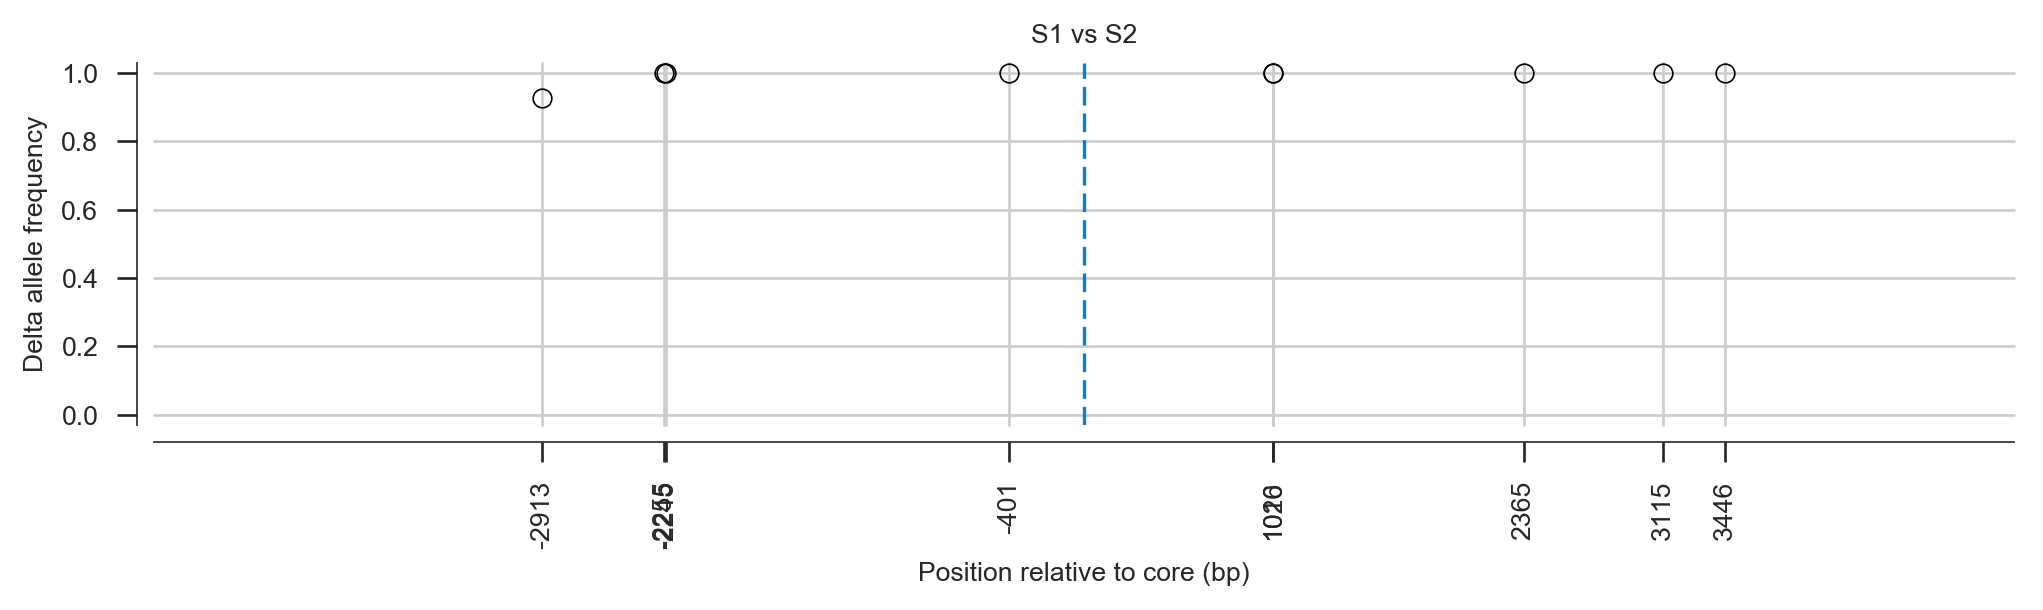

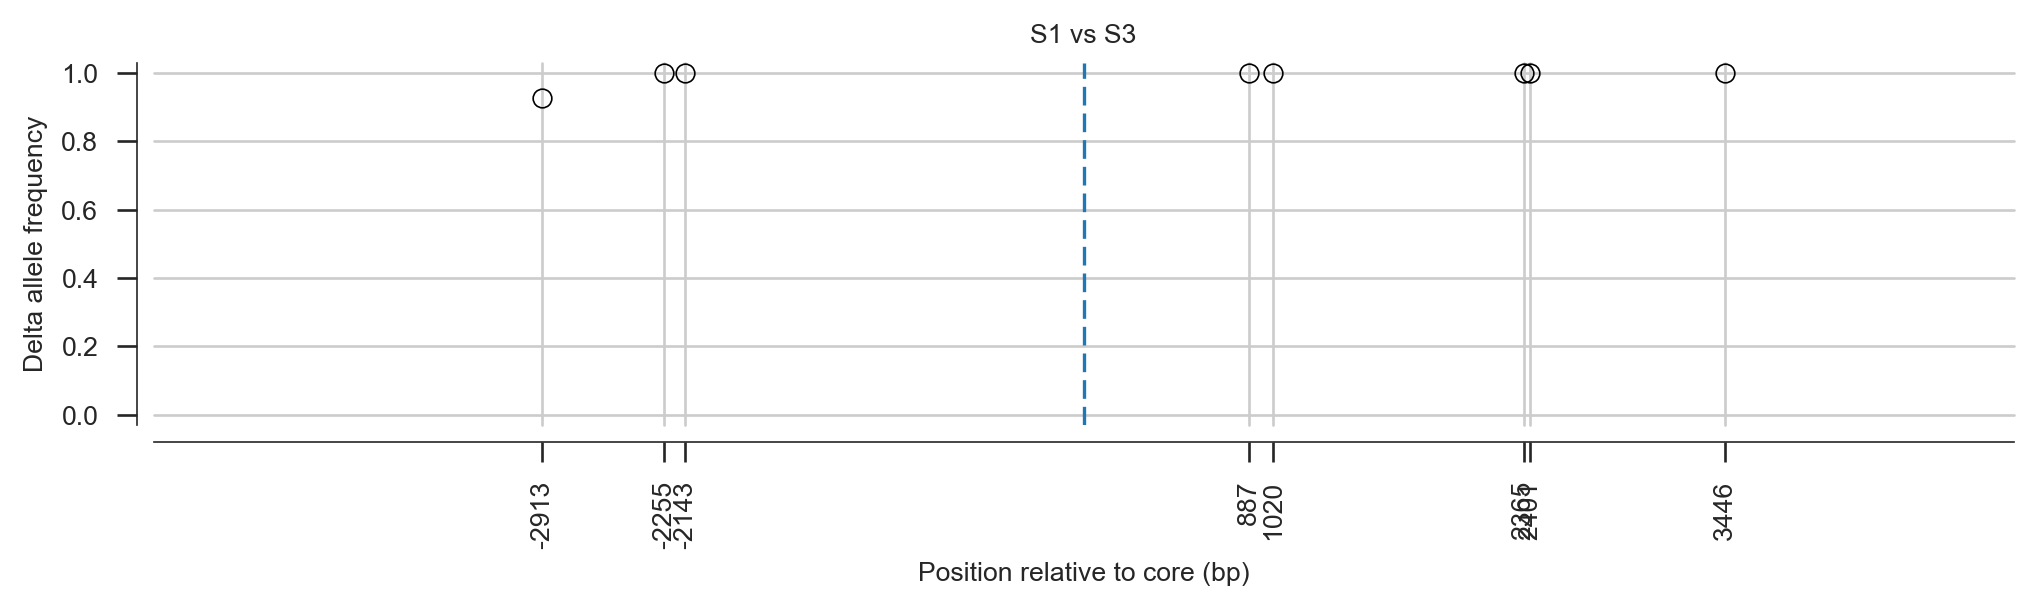

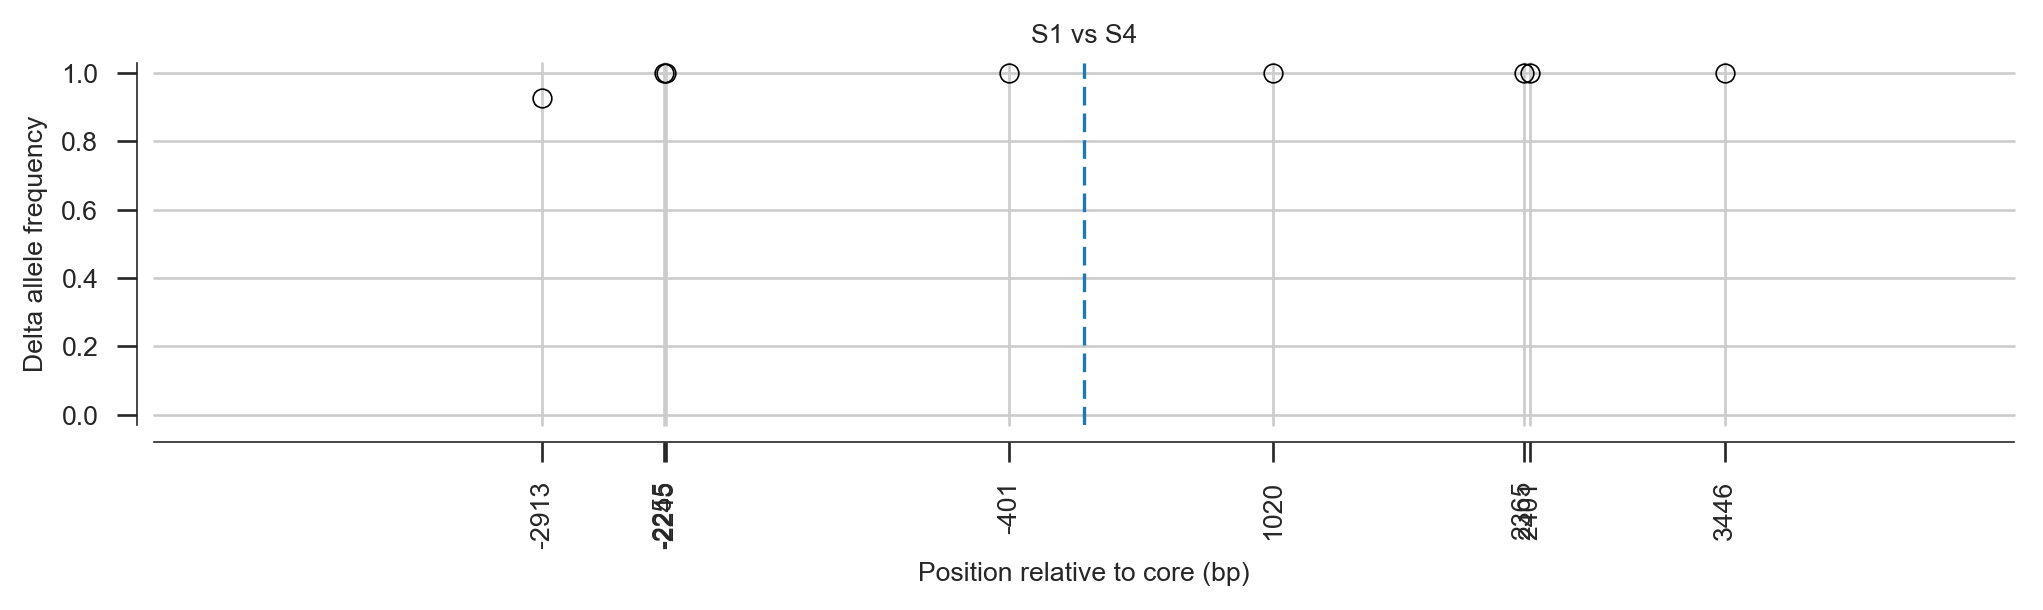

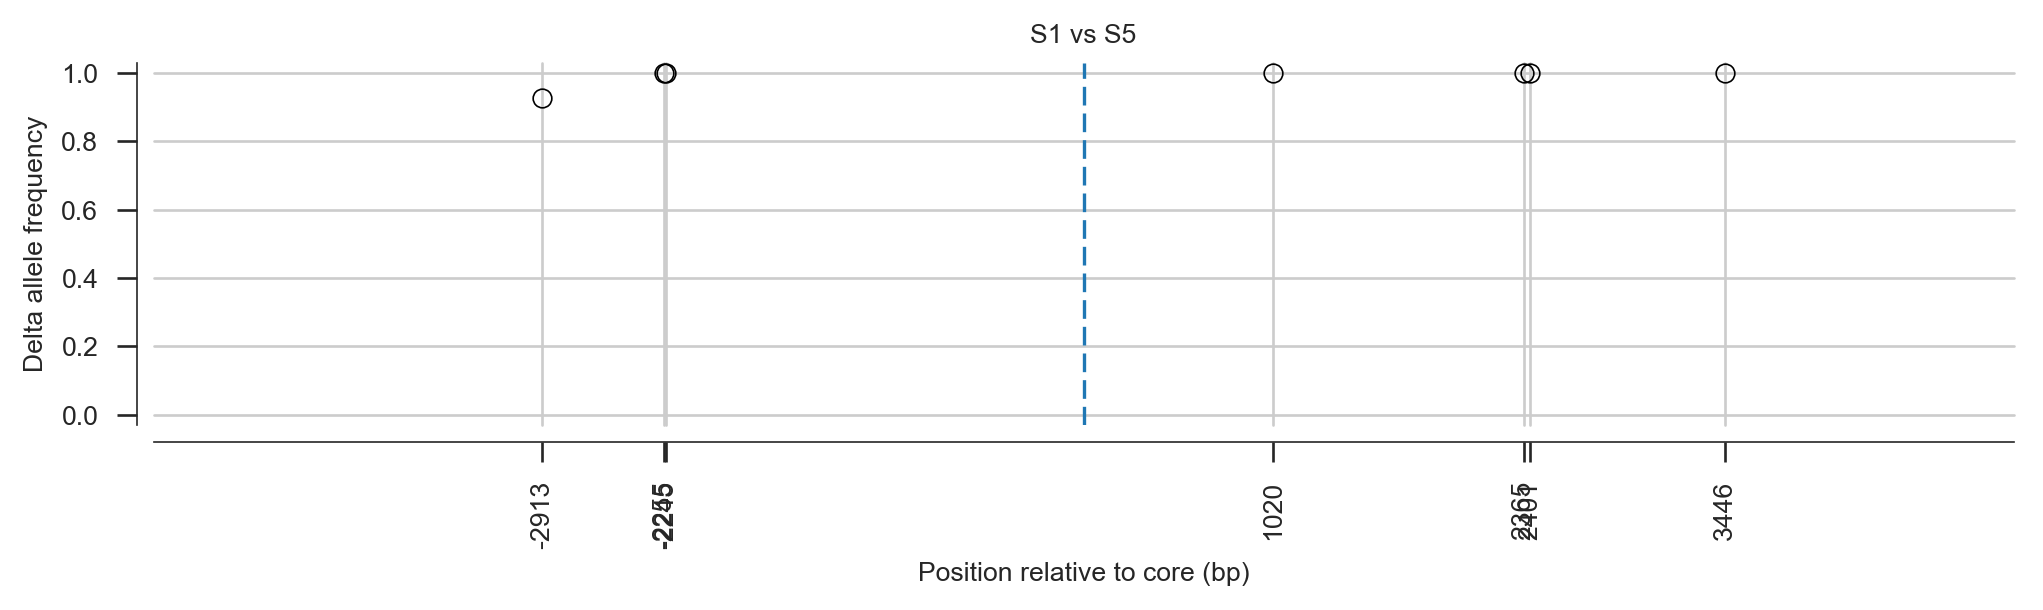

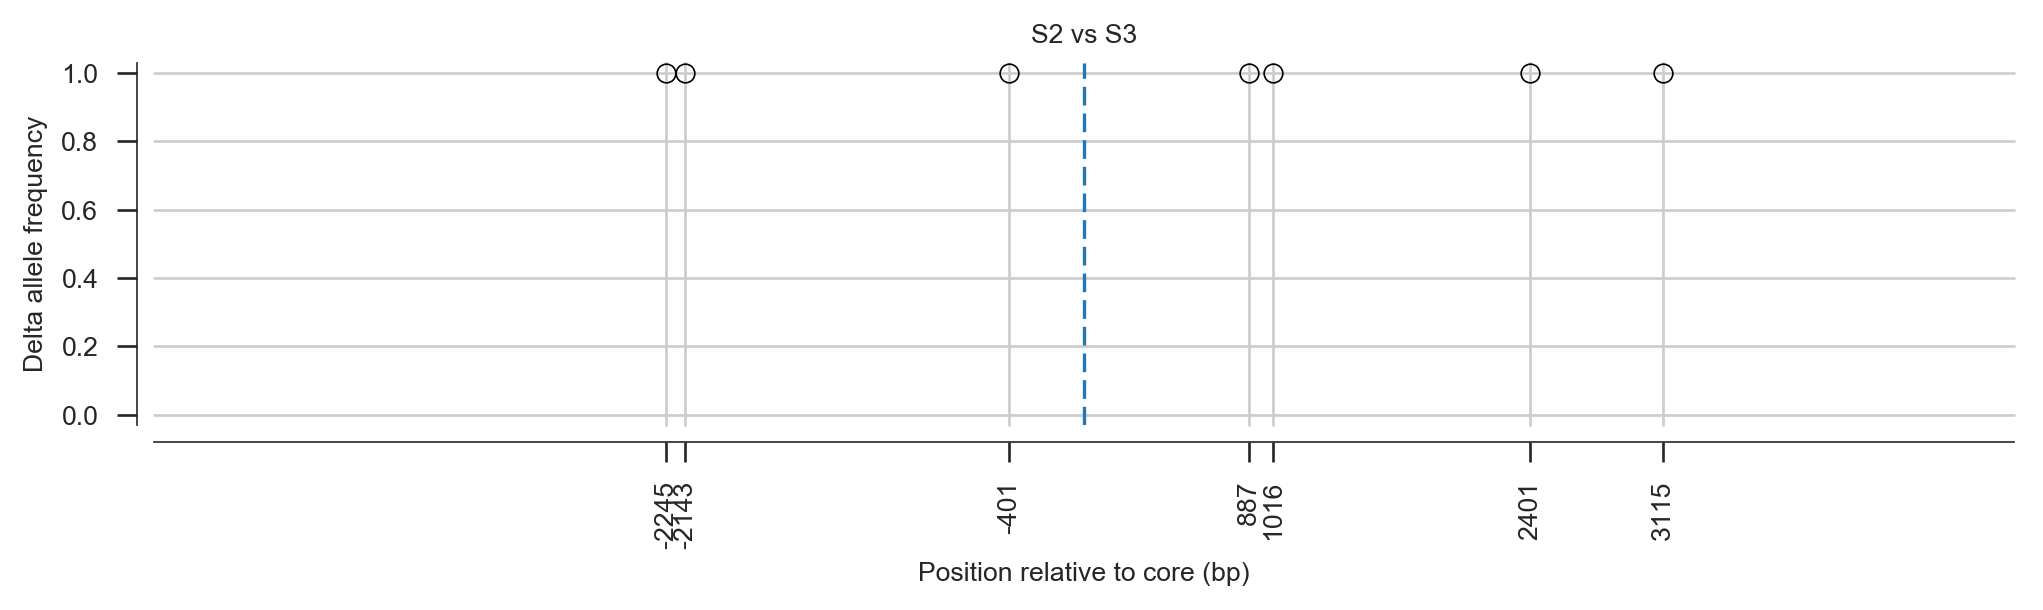

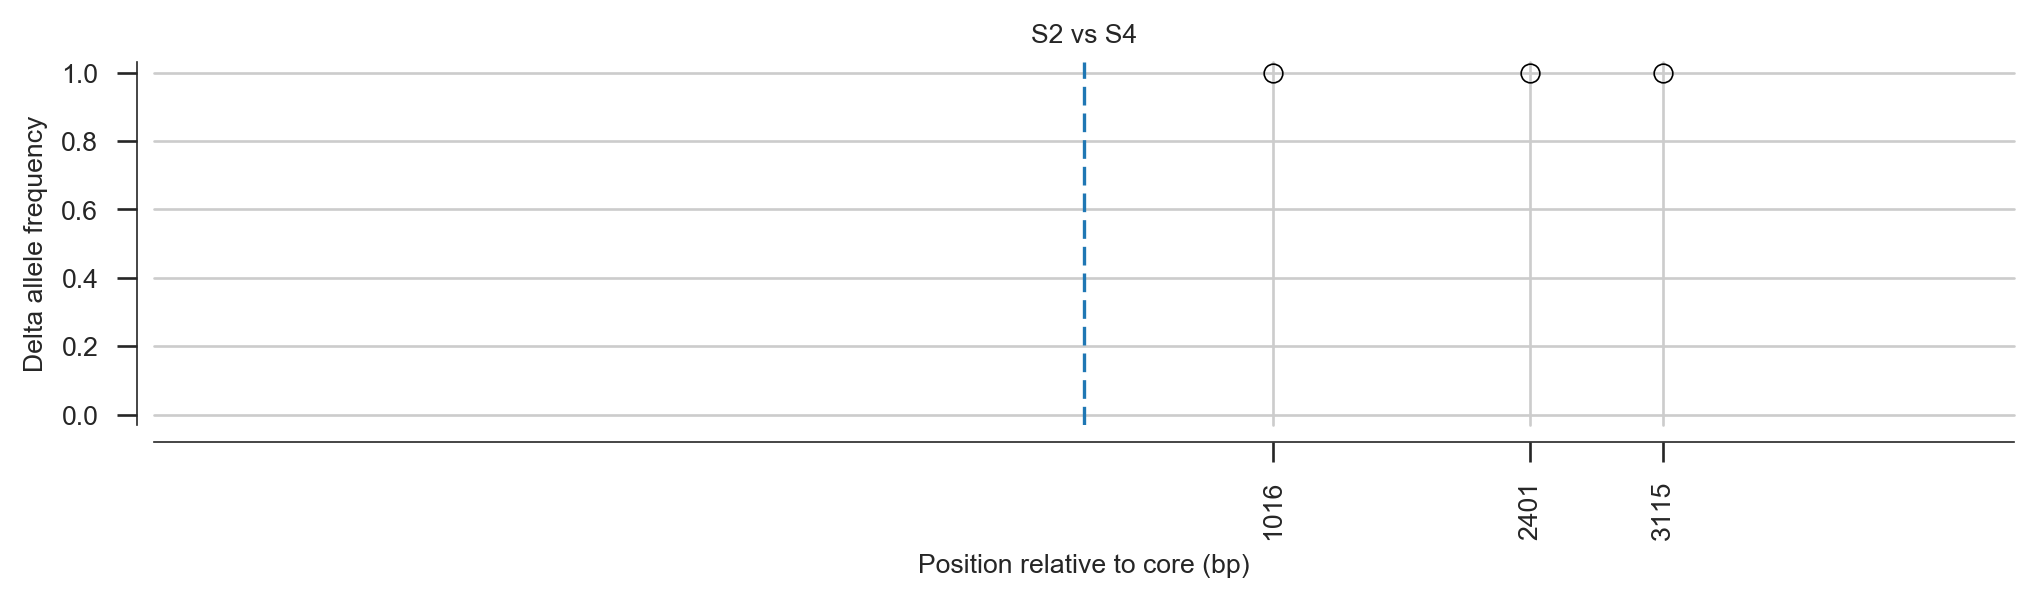

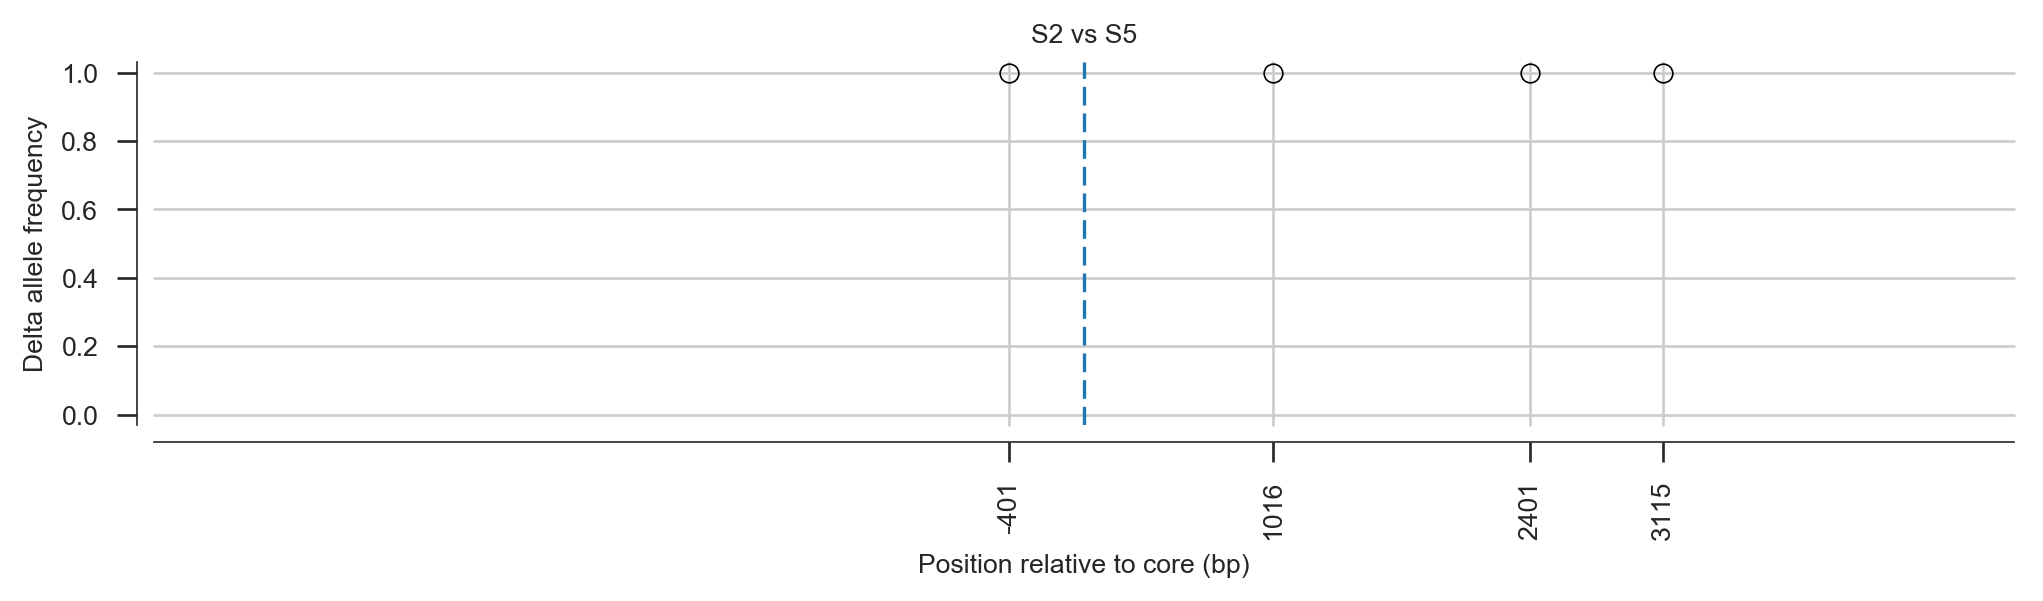

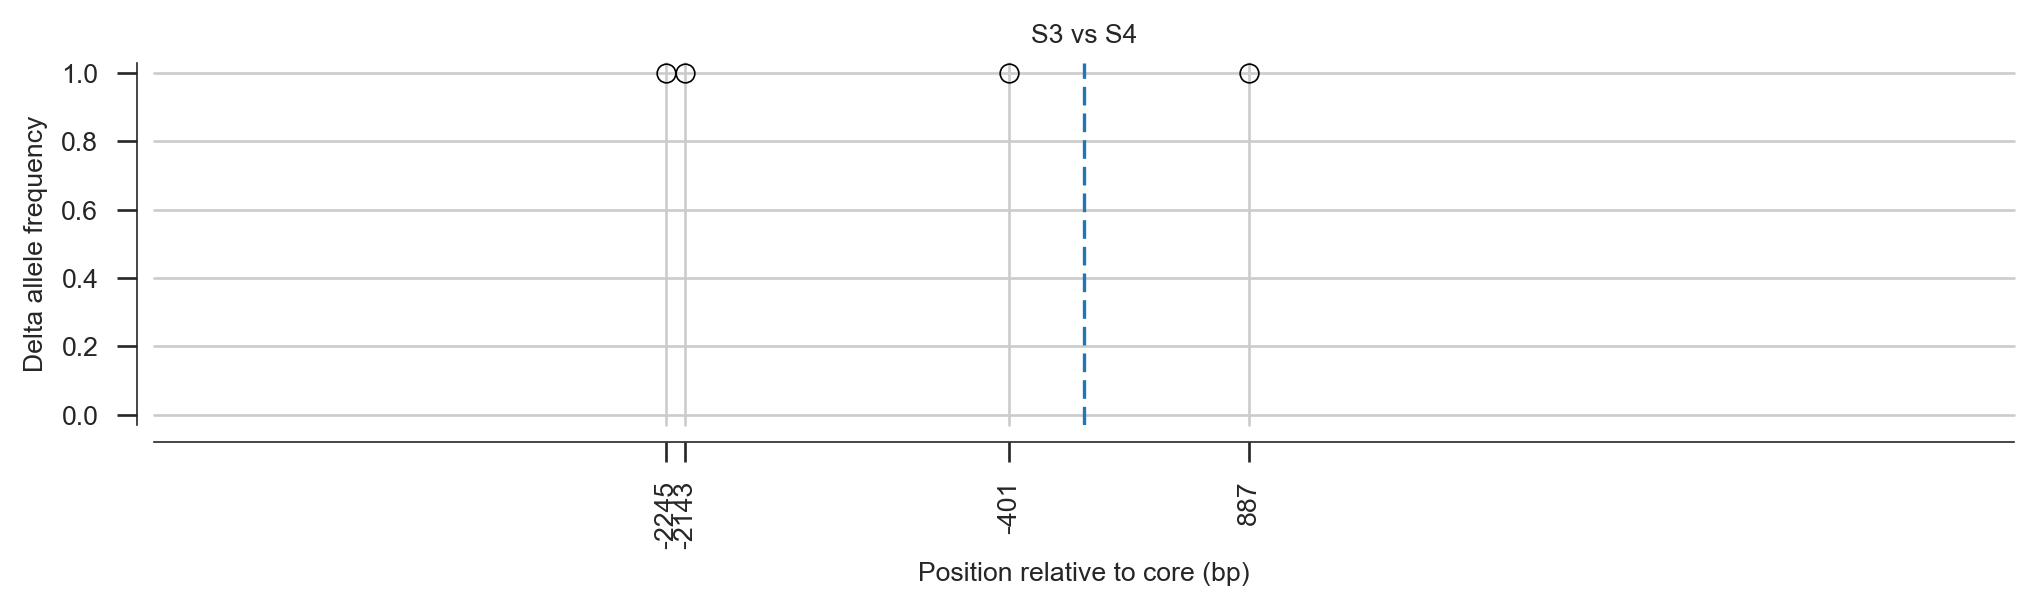

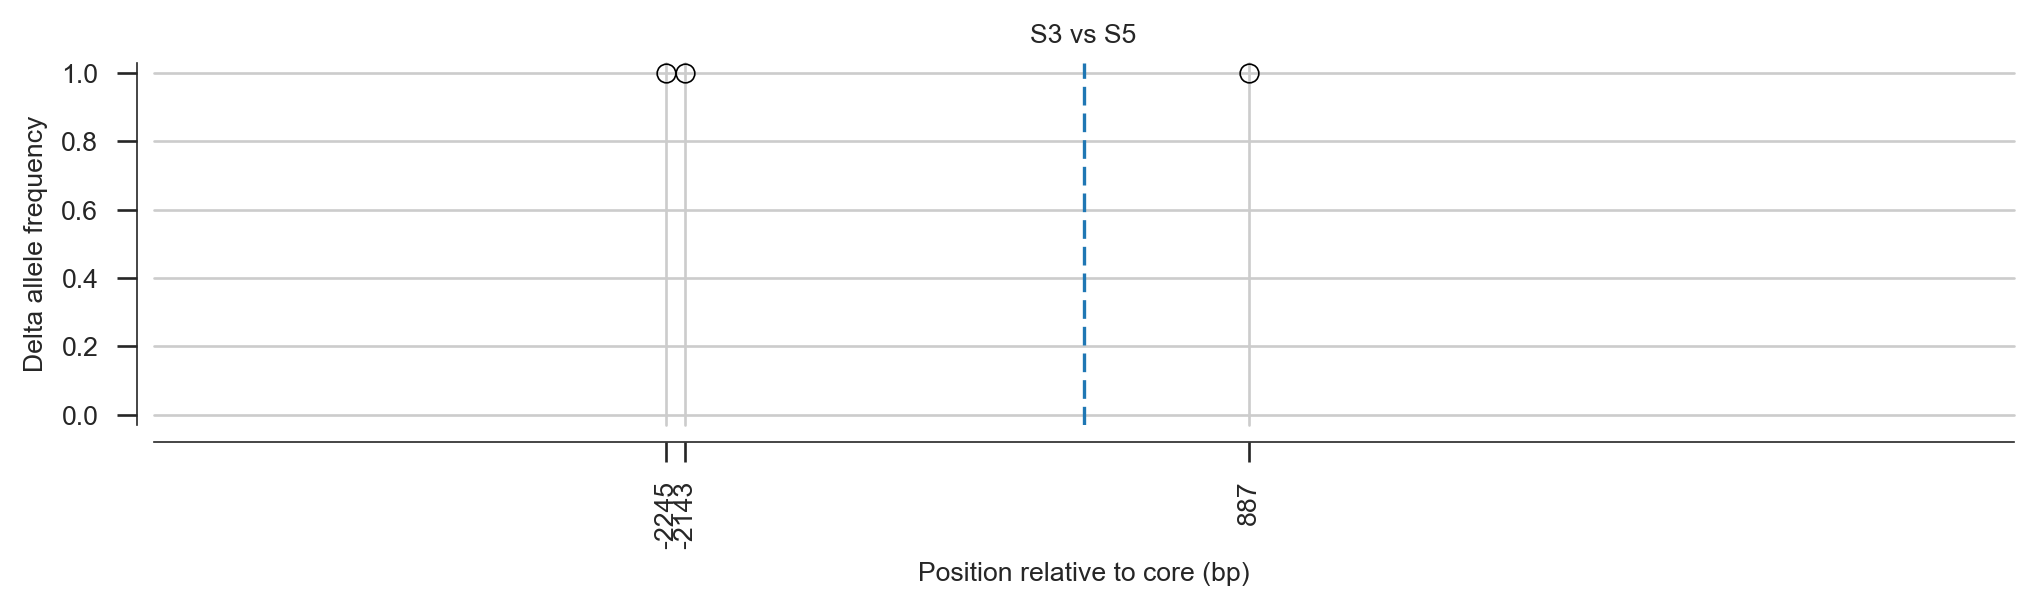

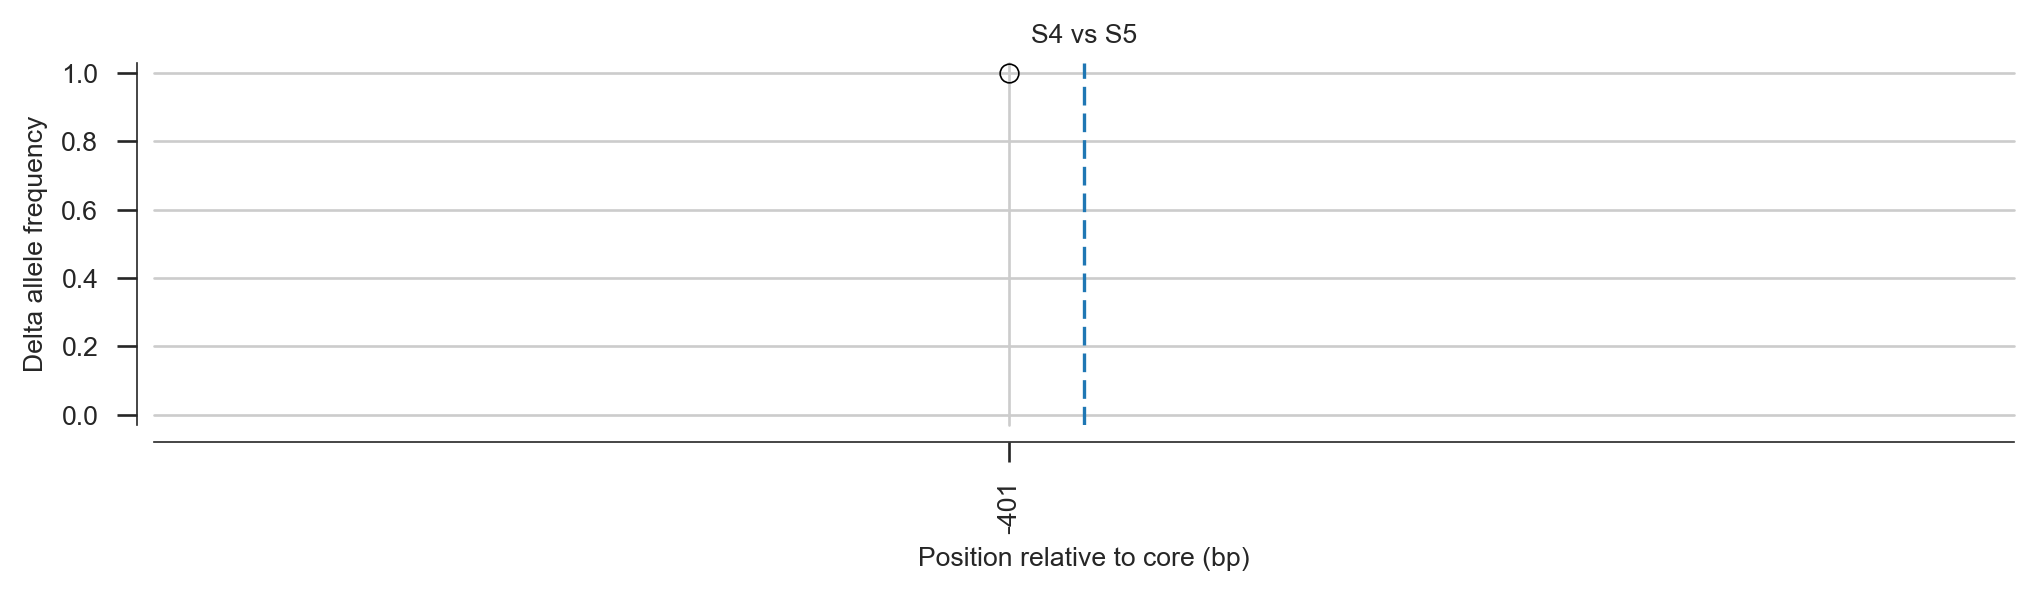

In [29]:
def analyse_995S_core_region():
    core = aa2pos['L995S']
    flank = 5000
    for set1, set2 in itertools.combinations(cluster_labels[5:], 2):
        plot_delta_af(core, flank, set1, set2)
        plt.show()
        
analyse_995S_core_region()

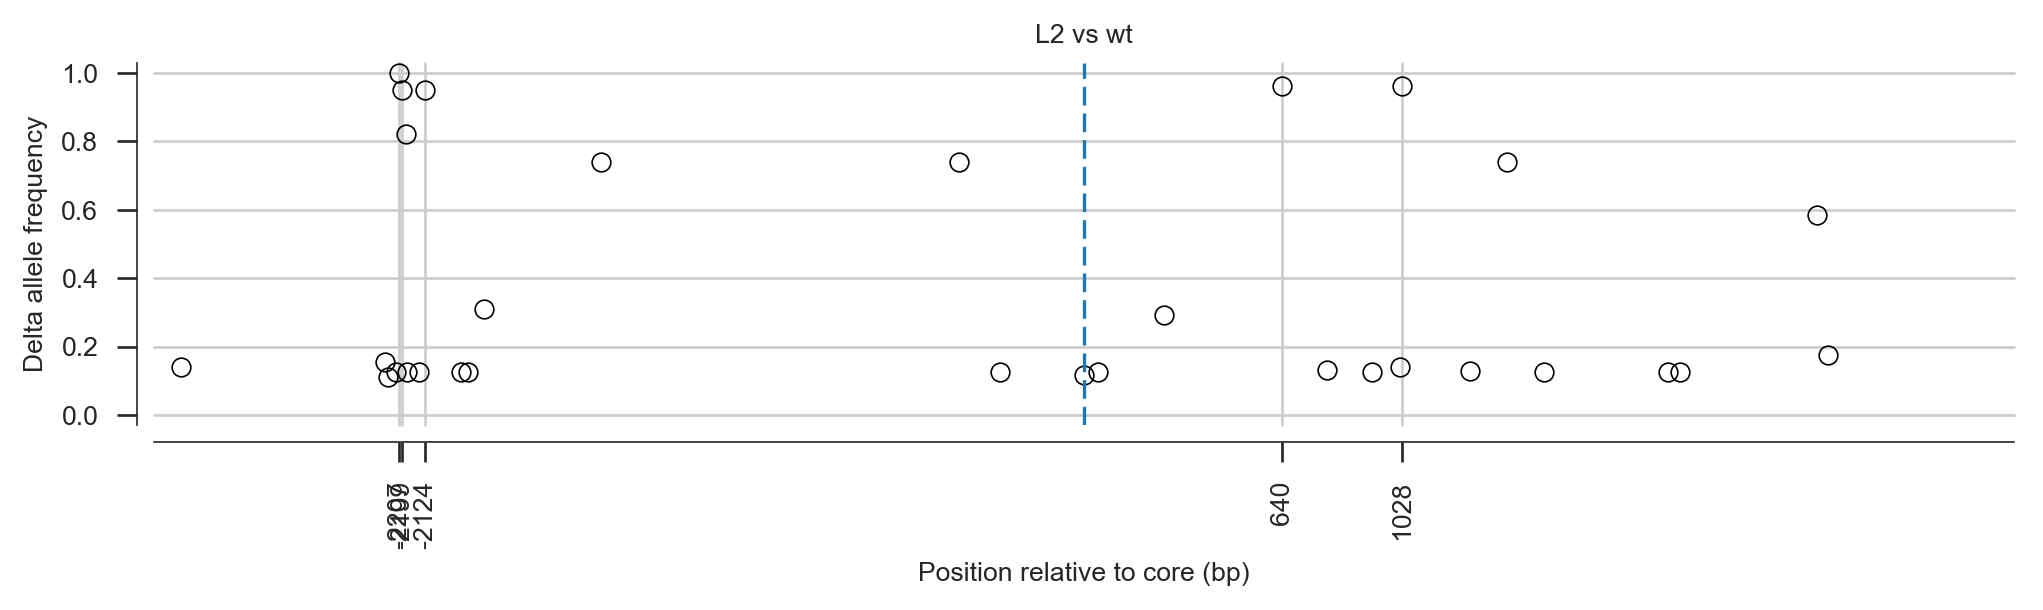

In [30]:
def analyse_L2_core_region():
    core = aa2pos['L995S']
    flank = 3000
    plot_delta_af(core, flank, 'L2', 'wt')
    plt.show()
        
analyse_L2_core_region()

In [31]:
def extract_core_haplotypes(start, stop):

    loc_region = pos_ehh.locate_range(start, stop)
    haps_region = haps_ehh[loc_region]
    ret = dict()

    distinct_sets = haps_region.distinct()
    wt_ix = 1
    fx_ix = 1
    sx_ix = 1
    lx_ix = 1
    for s in distinct_sets:
        isecs = [len(s.intersection(target_sets[l])) for l in target_labels]
        n_995F = len(s.intersection(haps_L995F))
        n_995S = len(s.intersection(haps_L995S))
        n_1527T = len(s.intersection(haps_I1527T))
        n_490I_1 = len(s.intersection(haps_M490I_1))
        label = target_labels[np.argmax(isecs)]
        if label == 'wt' or label in ret:
            if n_995F:
                label = 'FX%02d' % fx_ix
                fx_ix += 1
            elif n_995S:
                label = 'SX%02d' % sx_ix
                sx_ix += 1
            elif n_1527T or n_490I_1:
                label = 'LX%02d' % lx_ix
                lx_ix += 1
            else:
                label = 'WT%02d' % wt_ix
                wt_ix += 1
        ret[label] = s
        clust_isecs = ['%s:%s/%s (%.1f%%);' % (l, len(s.intersection(o)), len(o), len(s.intersection(o)) * 100 / len(o)) 
                       for l, o in sorted(target_sets.items()) if s.intersection(o)]
        mut_isecs = ['L995F:{}/{};'.format(n_995F, len(haps_L995F)), 
                     'L995S:{}/{};'.format(n_995S, len(haps_L995S)), 
                     'I1527T:{}/{};'.format(n_1527T, len(haps_I1527T)), 
                     'M490I.1:{}/{};'.format(n_490I_1, len(haps_M490I_1))]
        print('\t'.join([label, str(len(s))] + clust_isecs + mut_isecs))
            
    return ret

In [32]:
start = aa2pos['L995S'] - 2208
stop = aa2pos['L995S'] + 3870
core_haps = extract_core_haplotypes(start, stop)

F1	468	F1:459/464 (98.9%);	wt:9/316 (2.8%);	L995F:468/775;	L995S:0/430;	I1527T:0/19;	M490I.1:0/16;
F5	188	F5:187/196 (95.4%);	wt:1/316 (0.3%);	L995F:188/775;	L995S:0/430;	I1527T:0/19;	M490I.1:0/16;
S3	153	S3:153/165 (92.7%);	L995F:0/775;	L995S:153/430;	I1527T:0/19;	M490I.1:0/16;
S1	108	S1:108/108 (100.0%);	L995F:0/775;	L995S:108/430;	I1527T:0/19;	M490I.1:0/16;
S2	79	S2:79/79 (100.0%);	L995F:0/775;	L995S:79/430;	I1527T:0/19;	M490I.1:0/16;
F4	51	F4:38/38 (100.0%);	wt:13/316 (4.1%);	L995F:51/775;	L995S:0/430;	I1527T:0/19;	M490I.1:0/16;
WT01	48	wt:48/316 (15.2%);	L995F:0/775;	L995S:0/430;	I1527T:0/19;	M490I.1:0/16;
WT02	38	wt:38/316 (12.0%);	L995F:0/775;	L995S:0/430;	I1527T:0/19;	M490I.1:0/16;
WT03	37	wt:37/316 (11.7%);	L995F:0/775;	L995S:0/430;	I1527T:0/19;	M490I.1:0/16;
S4	37	S4:37/37 (100.0%);	L995F:0/775;	L995S:37/430;	I1527T:0/19;	M490I.1:0/16;
F3	36	F3:36/42 (85.7%);	L995F:36/775;	L995S:0/430;	I1527T:0/19;	M490I.1:0/16;
S5	36	S5:36/36 (100.0%);	L995F:0/775;	L995S:36/430;	I1527T:0/19;

In [33]:
# This is enough to get all core haplotypes, but includes a couple of wt GW in L2 which bring down EHH
# start = aa2pos['L995S'] - 402
# stop = aa2pos['L995S'] + 3870
# core_haps = extract_core_haplotypes(start, stop)

In [34]:
with open('../data/core_haps.pkl', mode='wb') as f:
    pickle.dump(core_haps, f)

## EHH decay plots

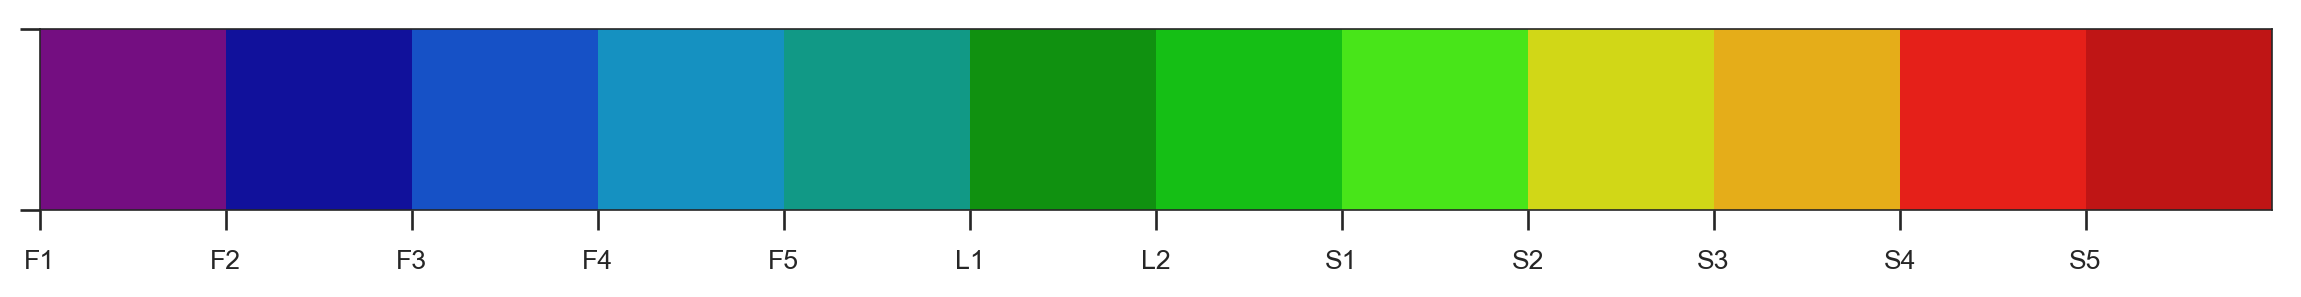

In [35]:
cluster_palette = sns.color_palette('nipy_spectral', n_colors=len(target_labels) - 1, desat=0.8)
sns.palplot(cluster_palette)
plt.gca().set_xticklabels(target_labels)
cluster_colors = dict(zip(target_labels, cluster_palette))  # don't include wt

In [36]:
sns.set_style('white')
sns.set_style('ticks')

In [37]:
def plot_ehh_decay(core, core_haps, flank=1000000, ax=None, cluster_colors=cluster_colors, min_cnt=14):
    
    loc_right = pos_ehh.locate_range(core, core + flank)
    haps_right = haps_ehh[loc_right]
    pos_right = pos_ehh[loc_right]

    loc_left = pos_ehh.locate_range(core - flank, core)
    haps_left = haps_ehh[loc_left]
    pos_left = pos_ehh[loc_left]
    
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 2.4))
        sns.despine(ax=ax, offset=5)

    labels = set()
    for l, s in core_haps.items():
        if len(s) < min_cnt:
            continue
            
        labels.add(l)
        
        if l in cluster_colors:
            color = cluster_colors[l]
            lw = 2
        else:
            color = 'k'
            lw = .5
        haps_right_core = haps_right.take(sorted(s), axis=1)
        haps_left_core = haps_left.take(sorted(s), axis=1)
        ehh_decay_right = allel.ehh_decay(haps_right_core)
        ehh_decay_left = allel.ehh_decay(haps_left_core[::-1])

        ax.plot(pos_right, ehh_decay_right, color=color, lw=lw)
        ax.plot(pos_left, ehh_decay_left[::-1], color=color, lw=lw)
        
    ax.set_xlim(core - flank, core + flank)
    ax.set_xlabel('Chromosome 2L position (Mbp)')
    ax.set_xticklabels(['%.1f' % (t/1e6) for t in ax.get_xticks()])
    ax.set_ylim(0, 1.02)
    ax.set_ylabel('EHH')
#     ax.grid(axis='y')
    
    handles = []
    for l in sorted(labels):
        if l in cluster_colors:
            color = cluster_colors[l]
            lw = 2
            label = l
            handles.append(plt.Line2D([0, 0], [0, 0], color=color, lw=lw, label=l))
    color = 'k'
    lw = .5
    handles.append(plt.Line2D([0, 0], [0, 0], color=color, lw=lw, label='$wt$'))
        
    legend = ax.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper right', labelspacing=.3,
                       frameon=False, framealpha=1, title='Core haplotype')
    plt.setp(legend.get_title(), fontsize=base_font_size)

    if fig:
        fig.tight_layout()


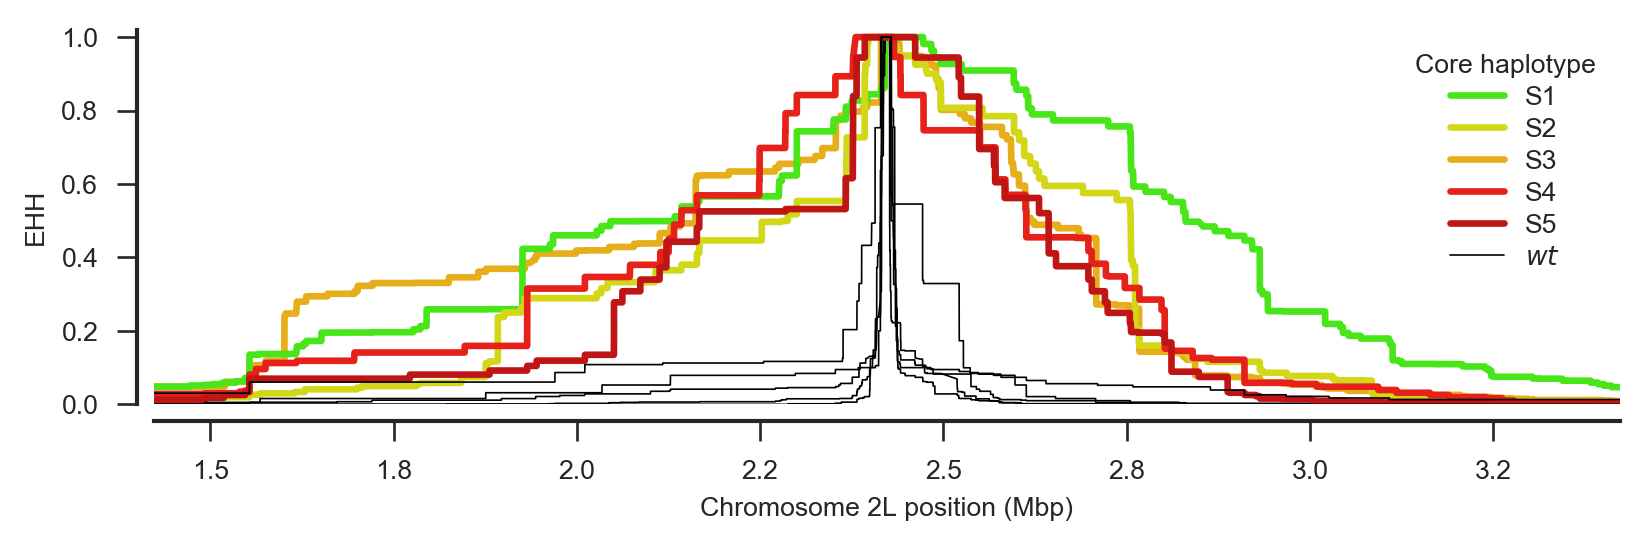

In [38]:
plot_ehh_decay(aa2pos['L995S'], {l: s for l, s in core_haps.items() if l.startswith('S') or l.startswith('WT')})

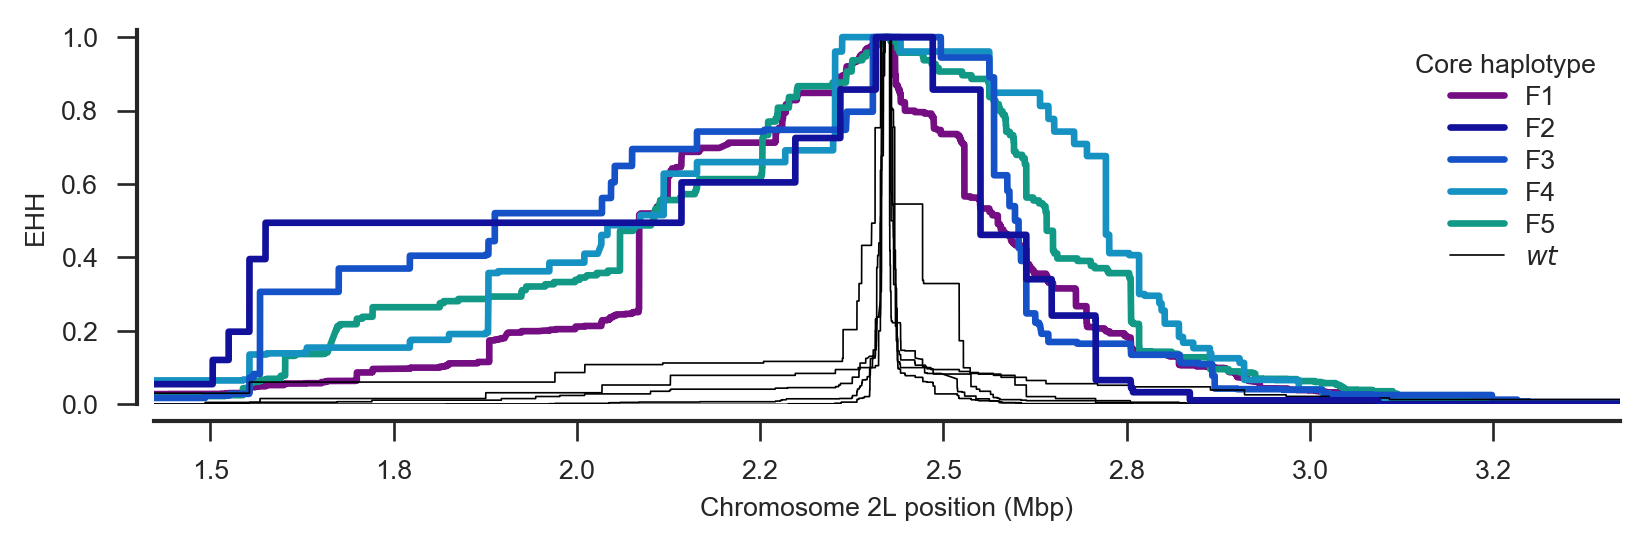

In [39]:
plot_ehh_decay(aa2pos['L995S'], {l: s for l, s in core_haps.items() if l.startswith('F') or l.startswith('WT')})

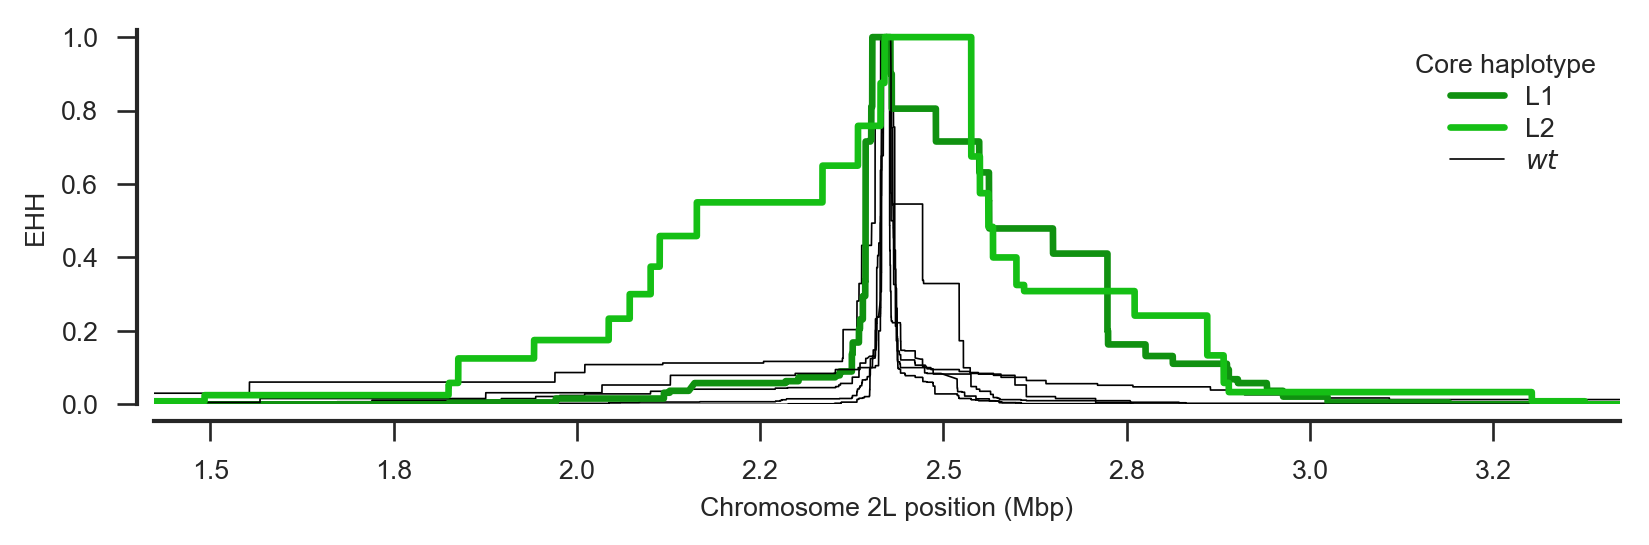

In [40]:
plot_ehh_decay(aa2pos['L995S'], {l: s for l, s in core_haps.items() if l.startswith('L') or l.startswith('WT')})

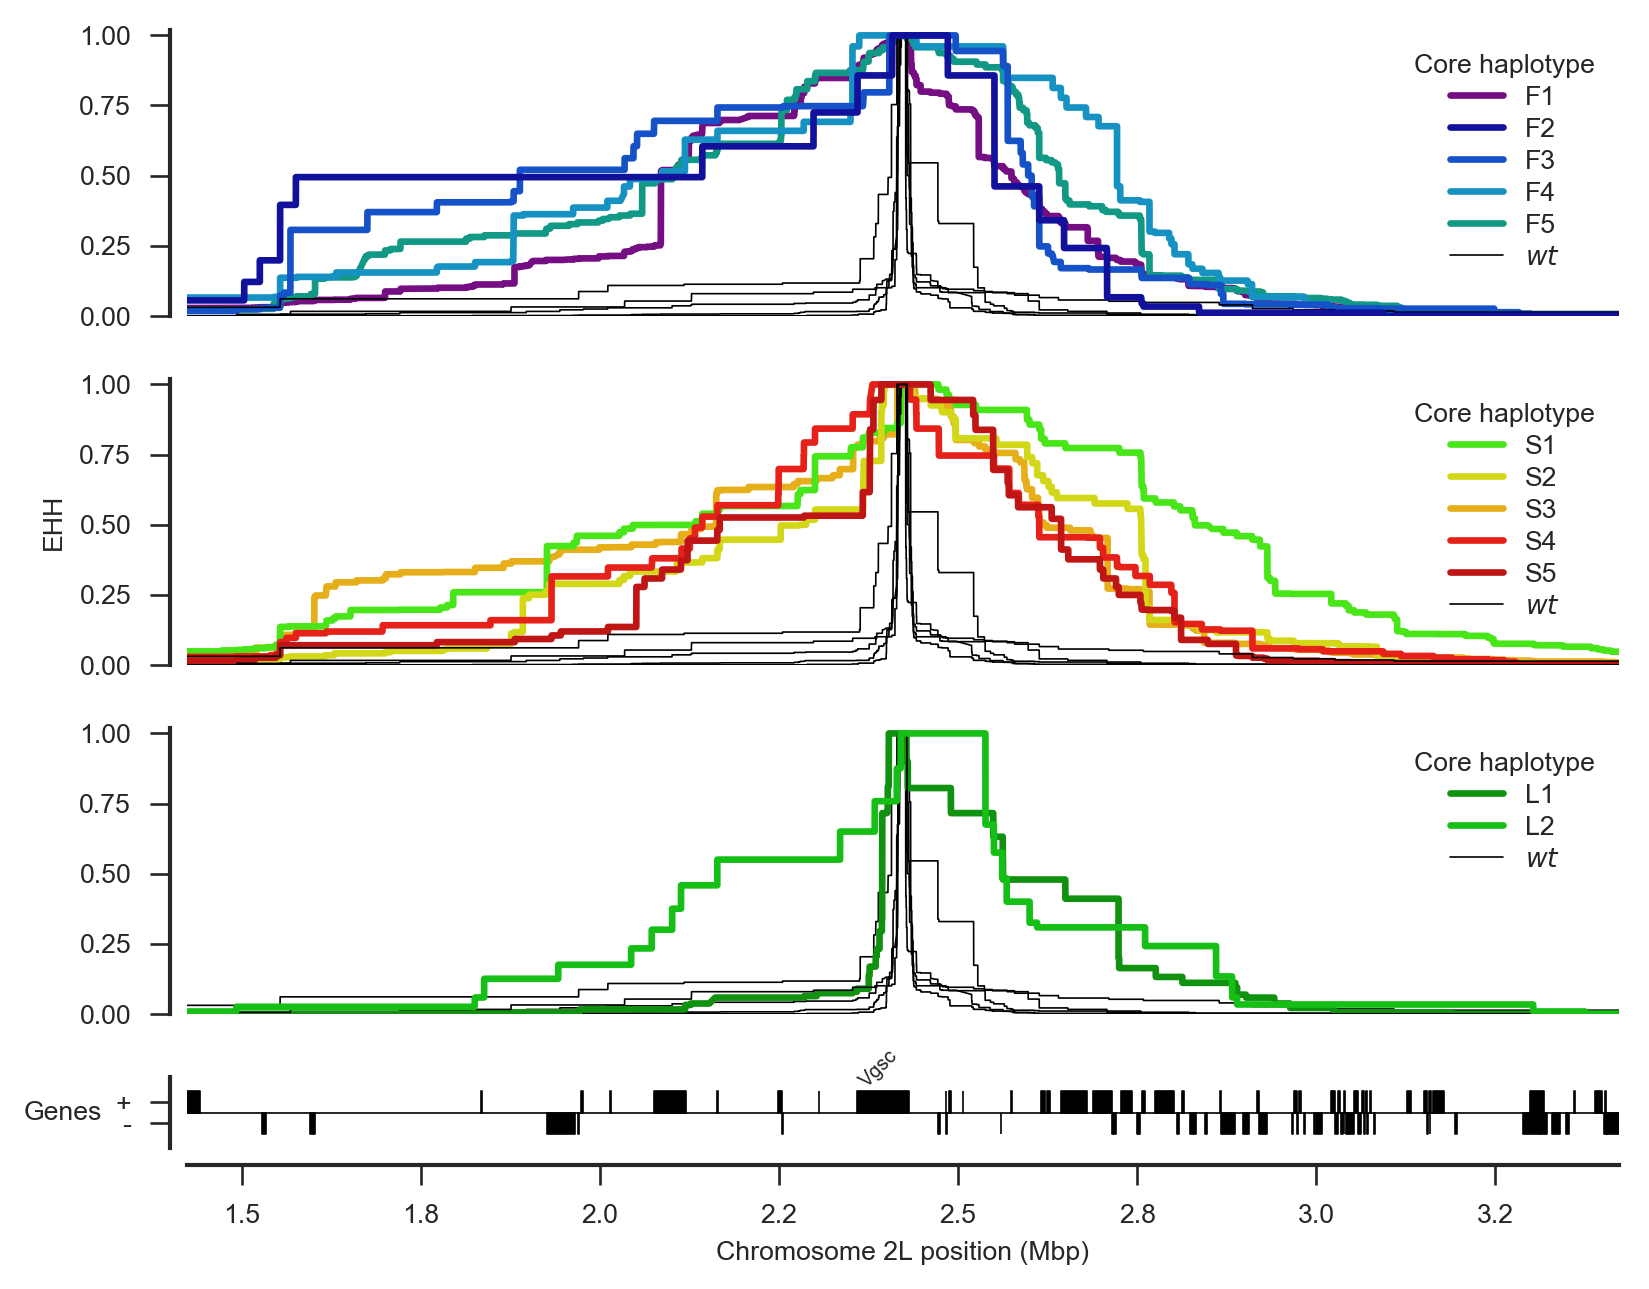

In [41]:
def fig_kdr_ehh_decay(figsize=(7, 5.5), fn=None, save_dpi=150):
    core = aa2pos['L995S']
    flank = 1000000

    fig = plt.figure(figsize=figsize)
    gs = mpl.gridspec.GridSpec(4, 1, height_ratios=[4, 4, 4, 1])

    ax = fig.add_subplot(gs[0])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, {l: s for l, s in core_haps.items() if l.startswith('F') or l.startswith('WT')}, 
                   ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, {l: s for l, s in core_haps.items() if l.startswith('S') or l.startswith('WT')}, 
                   ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('EHH')

    ax = fig.add_subplot(gs[2])
    sns.despine(ax=ax, bottom=True, offset=5)
    plot_ehh_decay(core, {l: s for l, s in core_haps.items() if l.startswith('L') or l.startswith('WT')}, ax=ax, flank=flank)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax = fig.add_subplot(gs[3])
    sns.despine(ax=ax, offset=5)
    plot_genes(phase1_ar3.genome_fn, phase1_ar3.geneset_agamp42_fn, ax=ax,
               chrom='2L', start=core-flank, stop=core+flank, labels=gene_labels, label=True, label_unnamed=False)    
    ax.set_xlabel('Chromosome 2L position (Mbp)')
    ax.set_xticklabels(['%.1f' % (t/1e6) for t in ax.get_xticks()])
    ax.set_ylabel('Genes')
    
    fig.tight_layout()
    if fn:
        fig.savefig(fn, bbox_inches='tight', dpi=save_dpi, jpeg_quality=100)
    
fig_kdr_ehh_decay(fn='../artwork/ehh_decay_old_clusters.pdf')

In [42]:
def build_f_breakdown():
    global f_breakdown
    f_breakdown = dict()
    
    f1_all = core_haps['F1']
    f1_vanilla = set(f1_all)
    for mut in 'T791M', 'N1570Y', 'E1597G', 'K1603T', 'V1853I', 'I1868T', 'P1874S', 'P1874L', 'A1934V':
        k = 'F1+{}'.format(mut)
        s_mut = set(np.nonzero(haps[pos.locate_key(aa2pos[mut]), :] == 1)[0])
        s = f1_all.intersection(s_mut)
        print(k, len(s_mut), len(s))
        f_breakdown[k] = s
        f1_vanilla = f1_vanilla - s
    f_breakdown['F1'] = f1_vanilla
    print('F1', len(f1_vanilla))

build_f_breakdown()
# for k, s in f_breakdown:
#     print(k, len(s))

F1+T791M 32 32
F1+N1570Y 110 107
F1+E1597G 11 11
F1+K1603T 7 7
F1+V1853I 13 13
F1+I1868T 52 52
F1+P1874S 29 29
F1+P1874L 80 79
F1+A1934V 16 16
F1 122


In [43]:
f_breakdown_labels = sorted(f_breakdown)

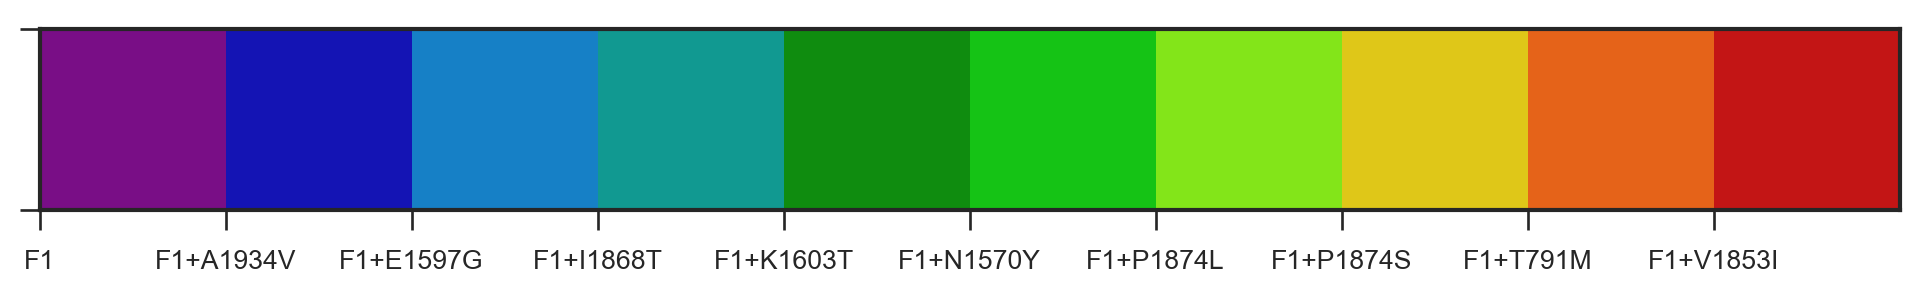

In [44]:
f_breakdown_palette = sns.color_palette('nipy_spectral', n_colors=len(f_breakdown), desat=0.8)
sns.palplot(f_breakdown_palette)
plt.gca().set_xticklabels(f_breakdown_labels)
f_breakdown_colors = dict(zip(f_breakdown_labels, f_breakdown_palette))  # don't include wt

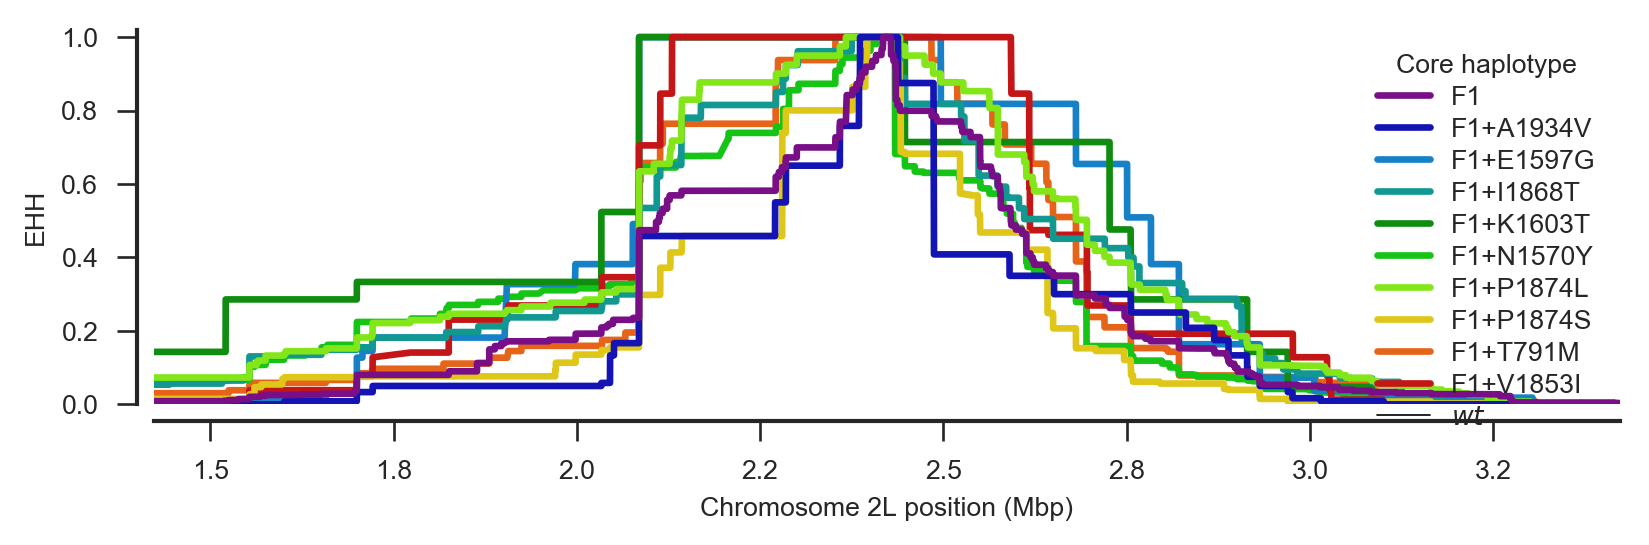

In [45]:
plot_ehh_decay(aa2pos['L995S'], f_breakdown, cluster_colors=f_breakdown_colors, min_cnt=1)

## Compare core haplotypes

In [46]:
import hapclust

In [47]:
# set core SNP
core_pos = aa2pos['L995S']

In [48]:
# split the EHH dataset
dist_ehh_right, dist_ehh_left, haps_ehh_right, haps_ehh_left = hapclust.split_flanks(haps_ehh, pos_ehh, core_pos)

In [49]:
def pairwise_haplotype_sharing(haps, dist, jitter=False):
    
    haps = allel.HaplotypeArray(haps)
    n_haplotypes = haps.n_haplotypes

    # compute length (no. variants) of shared prefix between pairs
    pspl = allel.opt.stats.pairwise_shared_prefix_lengths(
        np.asarray(haps, dtype='i1')
    )

    # compute length (physical distance) of shared prefix between neighbours
    pspd = hapclust._shared_distance(pspl, dist, jitter=jitter)

    return pspd


In [50]:
@functools.lru_cache(maxsize=None)
def compute_pspd(hap_ixs):
    
    # compute pairwise shared prefix distance
    pspd_left = pairwise_haplotype_sharing(haps_ehh_left.take(hap_ixs, axis=1), dist_ehh_left, jitter=True)
    pspd_right = pairwise_haplotype_sharing(haps_ehh_right.take(hap_ixs, axis=1), dist_ehh_right, jitter=True)
    
    return pspd_left, pspd_right

In [51]:
core_hap_labels = sorted([l for l, s in core_haps.items() if len(s) >= 14])

In [52]:
pspds = [compute_pspd(tuple(sorted(core_haps[l]))) for l in core_hap_labels]

In [53]:
pspds_adjusted = [pl * 0.3 * 2e-6 + pr * 2e-6 for pl, pr in pspds]

In [54]:
def boxplot_pspds(x, xlabels, figsize=(7, 3), colors=None, fn=None, ylabel=None, save_dpi=150):
    
    fig, ax = plt.subplots(figsize=figsize)
    bx = ax.boxplot(x, notch=True, bootstrap=1000, whis=[5, 95], showfliers=False, 
                    patch_artist=True,
                    medianprops=dict(linestyle='-', color='k'))
    #ax.set_yscale('log')
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Core haplotype')
    if ylabel:
        ax.set_ylabel(ylabel)
    if colors:
        for patch, color in zip(bx['boxes'], colors):
                patch.set_facecolor(color)
                
    ax.grid(axis='y')
    #ax.set_ylim(bottom=100000);
    if fn:
        fig.savefig(fn, bbox_inches='tight', dpi=save_dpi, jpeg_quality=100)


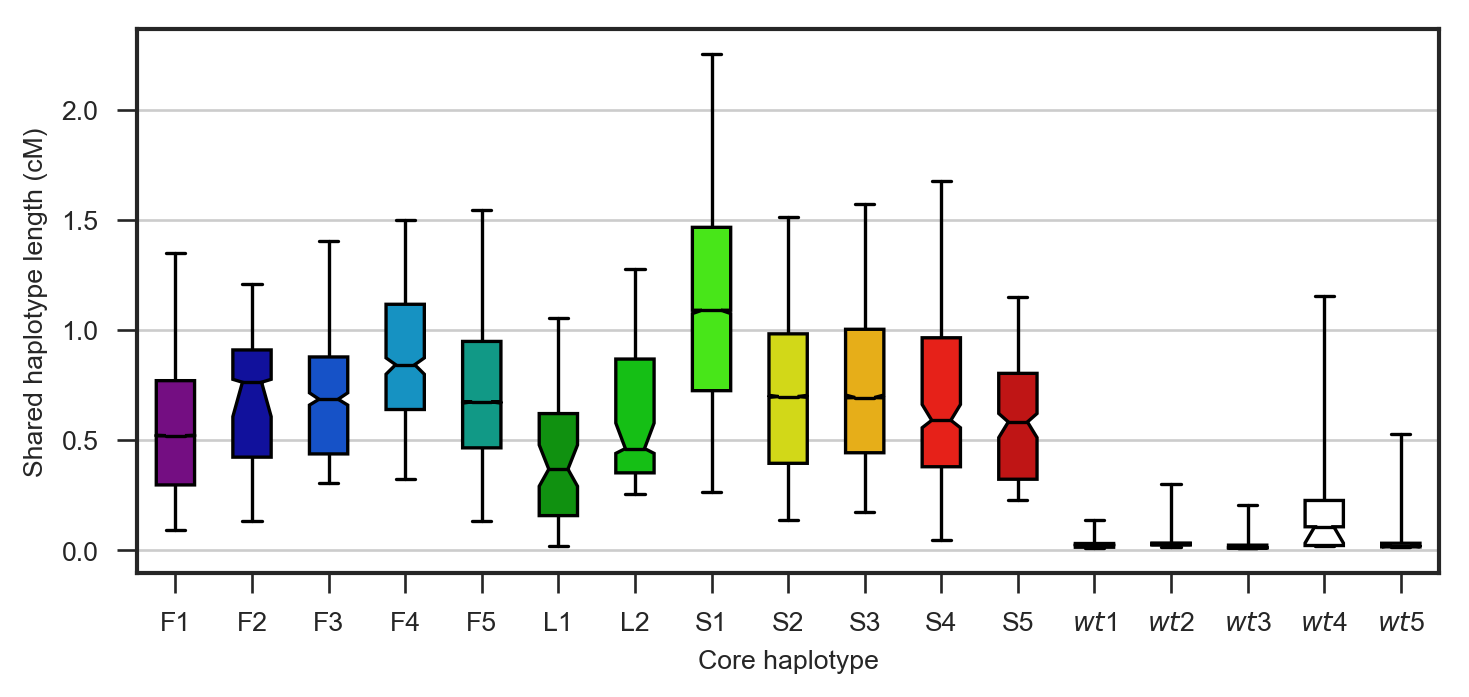

In [55]:
boxplot_pspds(pspds_adjusted, xlabels=[l.replace('WT0', '$wt$') for l in core_hap_labels], 
              colors=[cluster_colors.get(k, 'w') for k in core_hap_labels],
              fn='../artwork/clusters_compare_pspd.pdf', 
              ylabel='Shared haplotype length (cM)');

In [56]:
import scikits.bootstrap as bootstrap

In [57]:
for x, l in zip(pspds_adjusted, core_hap_labels):
    ci = bootstrap.ci(x, statfunction=np.median, n_samples=10000, method='pi')
    print('{} median {:.3f} cM (95% CI [{:.3f} - {:.3f}])'.format(l, np.median(x), ci[0], ci[1]))

F1 median 0.522 cM (95% CI [0.520 - 0.524])
F2 median 0.764 cM (95% CI [0.608 - 0.777])
F3 median 0.687 cM (95% CI [0.661 - 0.708])
F4 median 0.844 cM (95% CI [0.801 - 0.874])
F5 median 0.675 cM (95% CI [0.669 - 0.676])
L1 median 0.369 cM (95% CI [0.292 - 0.479])
L2 median 0.463 cM (95% CI [0.437 - 0.579])
S1 median 1.091 cM (95% CI [1.073 - 1.091])
S2 median 0.699 cM (95% CI [0.696 - 0.705])
S3 median 0.694 cM (95% CI [0.693 - 0.706])
S4 median 0.591 cM (95% CI [0.557 - 0.663])
S5 median 0.584 cM (95% CI [0.505 - 0.622])
WT01 median 0.025 cM (95% CI [0.023 - 0.026])
WT02 median 0.027 cM (95% CI [0.027 - 0.028])
WT03 median 0.012 cM (95% CI [0.012 - 0.012])
WT04 median 0.107 cM (95% CI [0.034 - 0.107])
WT05 median 0.021 cM (95% CI [0.017 - 0.023])


In [58]:
for x, l in zip(pspds_adjusted, core_hap_labels):
    ci = bootstrap.ci(x, statfunction=np.median, n_samples=10000, method='bca')
    print('{} median {:.3f} cM (95% CI [{:.3f} - {:.3f}])'.format(l, np.median(x), ci[0], ci[1]))

F1 median 0.522 cM (95% CI [0.520 - 0.524])
F2 median 0.764 cM (95% CI [0.608 - 0.777])
F3 median 0.687 cM (95% CI [0.661 - 0.710])
F4 median 0.844 cM (95% CI [0.801 - 0.874])
F5 median 0.675 cM (95% CI [0.669 - 0.676])
L1 median 0.369 cM (95% CI [0.292 - 0.479])
L2 median 0.463 cM (95% CI [0.437 - 0.579])
S1 median 1.091 cM (95% CI [1.073 - 1.091])
S2 median 0.699 cM (95% CI [0.696 - 0.705])
S3 median 0.694 cM (95% CI [0.693 - 0.706])
S4 median 0.591 cM (95% CI [0.556 - 0.663])
S5 median 0.584 cM (95% CI [0.508 - 0.622])
WT01 median 0.025 cM (95% CI [0.023 - 0.026])
WT02 median 0.027 cM (95% CI [0.027 - 0.028])
WT03 median 0.012 cM (95% CI [0.012 - 0.012])
WT04 median 0.107 cM (95% CI [0.034 - 0.107])
WT05 median 0.021 cM (95% CI [0.017 - 0.023])
